In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)

MAIN_COLOR = 'forestgreen'

In [3]:
df_train = pd.read_csv("./content/train.csv")
df_test = pd.read_csv("./content/test.csv")
df_calls = pd.read_csv("./content/Calls.csv", decimal=',')
df_connection_time = pd.read_csv("./content/ConnectionTime.csv", decimal=',')
df_ed = pd.read_csv("./content/Education.csv")
df_skud = pd.read_csv("./content/SKUD.csv", decimal=',')
df_tasks = pd.read_csv("./content/Tasks.csv")
df_timen = pd.read_csv("./content/TimenNetwork.csv")
df_work = pd.read_csv("./content/WorkingDay.csv")

/tmp/ipykernel_16129/3573146232.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_connection_time = pd.read_csv("./content/ConnectionTime.csv", decimal=',')
/tmp/ipykernel_16129/3573146232.py:7: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tasks = pd.read_csv("./content/Tasks.csv")


## Preprocess

In [4]:
df_full = pd.concat([df_test, df_train])
print(f"{df_train.shape[0]} + {df_test.shape[0]} = {df_full.shape[0]}")

550 + 262 = 812


In [5]:
all_ids = df_full['id'].to_list()

def remove_unused_id(data):
    df = data.copy()
    print(f"before: {df.shape[0]}")
    df = df[df['id'].isin(all_ids)]
    print(f"after: {df.shape[0]}")
    return df

## EDA

Helping functions

In [6]:
# def drop_all_duplicates(data):
#     df = data.copy()
    


def missing_values_table(df: pd.DataFrame, ascending=None, decimal_places=3) -> pd.DataFrame:
    ''' Create table with missing values
        ascending: None - no sort, False - descending sort, True - ascending sort
    '''
    mis_val = df.isna().sum()
    mis_val_percent = round(100 * df.isna().sum() / len(df), decimal_places)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Пропущенные значения', 1: '% Пропущенных значений'})
    if ascending is not None:
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 0] != 0]\
            .sort_values('% Пропущенных значений', ascending=ascending)

    return mis_val_table_ren_columns


def plot_dist(data, title='', xlabel='', ylabel='', binstep=0.05, figsize=(14,6)):
    ''' Plot histogram and boxplot '''

    _, (ax1, ax2) = plt.subplots(
        nrows=2, ncols=1,
        figsize=figsize
    )

    xticks_range = np.arange(data.min(), data.max() + 2*binstep, binstep)

    #ax1.hist(data, bins=np.arange(data.min(), data.max())-0.5, color='darkviolet', edgecolor='black')
    sns.histplot(data, bins=xticks_range - 0.5*binstep, color = MAIN_COLOR, ax = ax1)
    #ax2.boxplot(data.values, vert=False)
    sns.boxplot(x=data, color = MAIN_COLOR, ax = ax2)

    ax1.axvline(x=data.mean(), color='r', linestyle='-', label = 'Mean = {:.2f}'.format(data.mean()))
    ax1.axvline(x=data.median(), color='darkviolet', linestyle='-', label = 'Median = {:.2f}'.format(data.median()))

    q1, q3 = np.percentile(data.dropna(), [25 ,75])
    iqr = q3 - q1
    loval = q1 - 1.5 * iqr
    hival = q3 + 1.5 * iqr
    wiskhi = np.compress(data.values <= hival, data.values)
    wisklo = np.compress(data.values >= loval, data.values)
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)

    ax1.axvline(x=q1, color='cyan', linestyle='-', label = '25% = {:.2f}'.format(q1))
    ax1.axvline(x=q3, color='b', linestyle='-', label = '75% = {:.2f}'.format(q3))
    ax1.axvline(x=actual_loval, color='hotpink', linestyle='-', label = 'Q1 - IQR*1.5 = {:.2f}'.format(actual_loval))
    ax1.axvline(x=actual_hival, color='darkorange', linestyle='-', label = 'Q3 + IQR*1.5 = {:.2f}'.format(actual_hival))
    ax1.legend(loc='upper right', fontsize=8)

    ax1.set_xticks(xticks_range)
    ax1.xaxis.set_tick_params(labelsize=8)
    ax1.yaxis.set_tick_params(labelsize=8)
    ax1.set_title(title, fontsize=12)
    ax1.set_xlabel(xlabel, fontsize=10)
    ax1.set_ylabel(ylabel, fontsize=10)
    ax1.grid(axis='y')

    ax2.set_xlim(ax1.get_xlim())    # sync 'x' axis of axes
    ax2.set_xticks(xticks_range)
    ax2.xaxis.set_tick_params(labelsize=8)
    ax2.yaxis.set_tick_params(labelsize=8)
    ax2.set_xlabel(xlabel, fontsize=10)
    ax2.grid()

    plt.show()


def plot_barh(data, x:str, y:str, title:str = '', x_axis:str = None, y_axis:str = None, color='green', top=None, figsize=(10,2)):
    ''' Функция создаёт столбчатую горизонтальную диаграмму по заданному столбцу датафрейма '''

    if not x_axis:
        x_axis = x
    if not y_axis:
        y_axis = y

    if top:
        df_dict = dict(data[[x, y]][y].value_counts()[:top])
    else:
        df_dict = dict(data[[x, y]][y].value_counts())
    all_data = sum(dict(data[[x, y]][y].value_counts()).values())

    plt.figure(figsize=figsize)

    plt.barh(range(len(df_dict)), list(df_dict.values()), align='center', height=0.85, color=color) 
    plt.yticks(range(len(df_dict)), list(df_dict.keys()))
    plt.title(title, fontsize=12)
    plt.grid()
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.xlabel(x_axis, fontsize=10)
    plt.ylabel(y_axis, fontsize=10)

    for i, v in enumerate(list(df_dict.values())): 
        plt.text(v+5, i+0.1, str(round(v*100/all_data,2))+'%', fontsize='10') 

    plt.show()

## Target

In [7]:
df_train['type'].value_counts()

2    298
0    153
1     74
3     25
Name: type, dtype: int64

In [8]:
df_train_org = df_train.copy()
df_train_org['id_org'] = df_train_org['id'].apply(lambda x: str(x).split('-')[0])
df_train_org

id  type id_org
0    ОРГ1-02050     2   ОРГ1
1    ОРГ1-02783     2   ОРГ1
2    ОРГ2-06173     0   ОРГ2
3    ОРГ2-05359     2   ОРГ2
4    ОРГ1-00803     2   ОРГ1
..          ...   ...    ...
545  ОРГ1-02587     2   ОРГ1
546  ОРГ1-02383     2   ОРГ1
547  ОРГ1-02862     2   ОРГ1
548  ОРГ1-00471     2   ОРГ1
549  ОРГ2-02694     2   ОРГ2

[550 rows x 3 columns]

In [9]:
df_train_org.groupby(['id_org', 'type']).agg('count')

id
id_org type     
ОРГ1   0     109
       1      30
       2     243
       3      24
ОРГ2   0      44
       1      44
       2      55
       3       1

In [10]:
df_org = pd.concat([df_train, df_test])
df_org['id_org'] = df_org['id'].apply(lambda x: str(x).split('-')[0])
df_org = df_org.drop('type', axis=1)

### Calls - данные о звонках

In [11]:
df_calls = remove_unused_id(df_calls)

before: 407867
after: 190350


In [12]:
df_calls.head(3)

Date  CallTime  NumberOfCalls Вид учета времени   InOut  \
0  2021-08-16 00:00:00,000  0.000278              1             Будни  ToUser   
1  2021-09-21 00:00:00,000  0.000278              1             Будни  ToUser   
2  2021-01-11 00:00:00,000  0.000278              1             Будни  ToUser   

           id  
0  ОРГ1-01945  
1  ОРГ1-01945  
2  ОРГ1-01945

In [13]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190350 entries, 0 to 407866
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               190350 non-null  object 
 1   CallTime           190350 non-null  float64
 2   NumberOfCalls      190350 non-null  int64  
 3   Вид учета времени  186351 non-null  object 
 4   InOut              190350 non-null  object 
 5   id                 190350 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 10.2+ MB


In [14]:
missing_values_table(df_calls, ascending=False)

Пропущенные значения  % Пропущенных значений
Вид учета времени                  3999                   2.101

In [15]:
df_calls['Вид учета времени'] = df_calls['Вид учета времени'].fillna('Будни')

In [16]:
df_calls[df_calls.duplicated()].sort_values(['id', 'Date'])

Date  CallTime  NumberOfCalls Вид учета времени  \
135258  2021-01-11 00:00:00,000  0.025278              1             Будни   
135259  2021-01-11 00:00:00,000  0.021667              1             Будни   
205928  2021-01-11 00:00:00,000  0.165000             11             Будни   
357002  2021-01-11 00:00:00,000  0.036111              2             Будни   
244376  2021-01-12 00:00:00,000  0.103611              7             Будни   
...                         ...       ...            ...               ...   
131966  2021-11-22 00:00:00,000  0.138611              1             Будни   
131977  2021-11-25 00:00:00,000  0.446667              1             Будни   
131978  2021-11-25 00:00:00,000  0.396944              1             Будни   
131991  2021-11-30 00:00:00,000  0.080833              1             Будни   
353626  2021-12-27 00:00:00,000  0.000556              2             Будни   

           InOut          id  
135258    ToUser  ОРГ1-00655  
135259    ToUser  ОРГ1-00655  
205928    ToUser  ОРГ1-00655  
357002  FromUser  ОРГ1-00655  
244376  FromUser  ОРГ1-00655  
...          ...         ...  
131966  FromUser  ОРГ2-05295  
131977  FromUser  ОРГ2-05295  
131978  FromUser  ОРГ2-05295  
131991  FromUser  ОРГ2-05295  
353626  FromUser  ОРГ2-05295  

[3452 rows x 6 columns]

In [17]:
df_calls[df_calls[['Date', 'id', 'CallTime']].duplicated()].sort_values(['id', 'Date'])

Date  CallTime  NumberOfCalls Вид учета времени  \
102174  2021-01-11 00:00:00,000  0.040556              1             Будни   
365639  2021-07-08 00:00:00,000  0.004722              2             Будни   
365864  2021-07-13 00:00:00,000  0.096944              2             Будни   
368515  2021-09-07 00:00:00,000  0.093889              2             Будни   
390008  2021-09-08 00:00:00,000  0.277222              2             Будни   
...                         ...       ...            ...               ...   
131966  2021-11-22 00:00:00,000  0.138611              1             Будни   
131977  2021-11-25 00:00:00,000  0.446667              1             Будни   
131978  2021-11-25 00:00:00,000  0.396944              1             Будни   
131991  2021-11-30 00:00:00,000  0.080833              1             Будни   
353626  2021-12-27 00:00:00,000  0.000556              2             Будни   

           InOut          id  
102174  FromUser  ОРГ1-00057  
365639  FromUser  ОРГ1-00057  
365864  FromUser  ОРГ1-00057  
368515  FromUser  ОРГ1-00057  
390008    ToUser  ОРГ1-00057  
...          ...         ...  
131966  FromUser  ОРГ2-05295  
131977  FromUser  ОРГ2-05295  
131978  FromUser  ОРГ2-05295  
131991  FromUser  ОРГ2-05295  
353626  FromUser  ОРГ2-05295  

[9384 rows x 6 columns]

In [18]:
df_calls[df_calls[['Date', 'id', 'CallTime']].duplicated()].sort_values(['id', 'Date']).value_counts('id')

id
ОРГ1-01091    916
ОРГ1-00655    912
ОРГ1-01193    636
ОРГ1-01958    569
ОРГ1-02606    413
             ... 
ОРГ1-02759      1
ОРГ1-02192      1
ОРГ1-00696      1
ОРГ1-02813      1
ОРГ1-02646      1
Length: 357, dtype: int64

In [19]:
df_calls = df_calls.drop_duplicates()
df_calls.shape

(186898, 6)

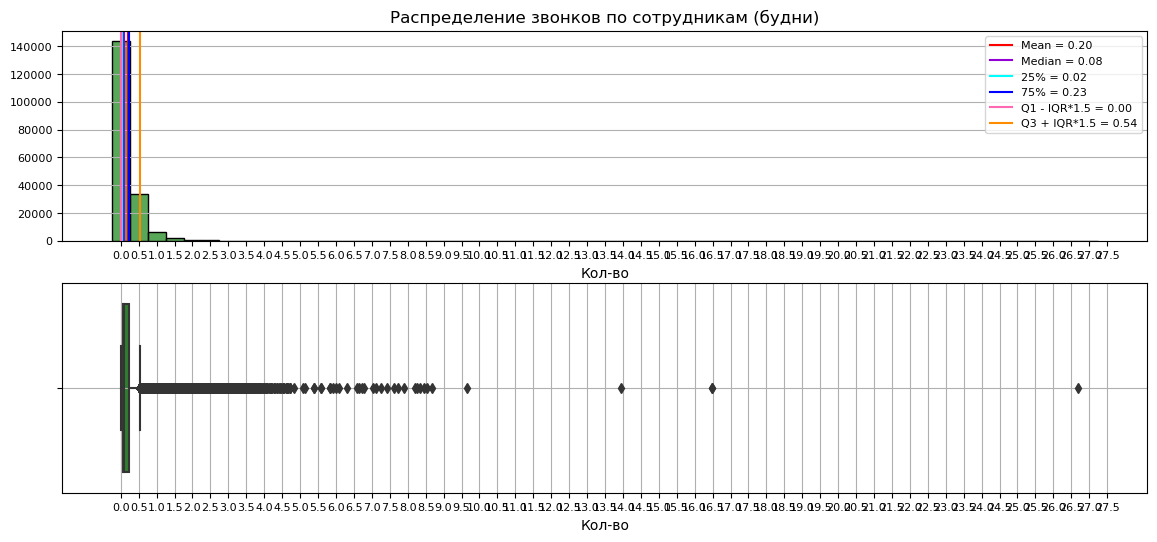

In [20]:
data = df_calls['CallTime']
plot_dist(data, title='Распределение звонков по сотрудникам (будни)', xlabel='Кол-во', binstep=0.5)

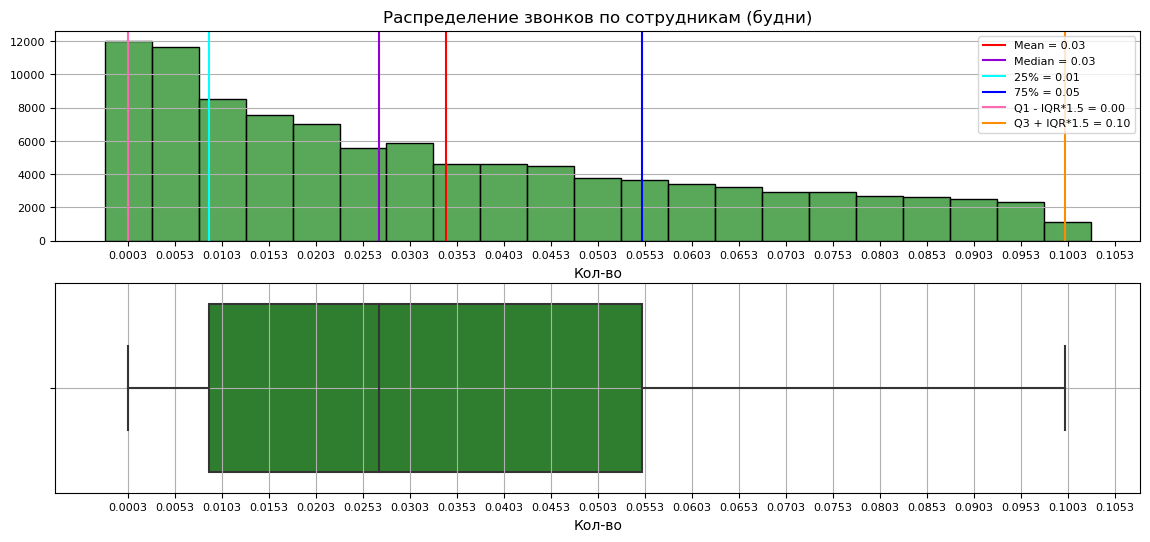

In [21]:
data = df_calls[df_calls['CallTime'] < 0.1]['CallTime']
plot_dist(data, title='Распределение звонков по сотрудникам (будни)', xlabel='Кол-во', binstep=0.005)

In [22]:
df_calls['CallTime'] = df_calls['CallTime'].apply(lambda x: 0 if (x < 0.01 or x > 1.5) else x)

Звонки по будням и выходным (можно дополнительно определять входящие и исходящие)

In [23]:
df_calls = df_calls.rename(columns={'Вид учета времени': 'Weekday'})

In [24]:
call_pivot = pd.pivot_table(df_calls[['id', 'Weekday', 'NumberOfCalls']], index='id', columns='Weekday', aggfunc=sum, fill_value=0)
call_pivot.columns = call_pivot.columns.droplevel(0)
call_pivot = call_pivot.rename_axis(None, axis=1)
call_pivot = call_pivot.rename(columns={'Будни': 'calls_weekday_sum', 'Выходные дни': 'calls_weekend_sum'})
call_pivot

calls_weekday_sum  calls_weekend_sum
id                                              
ОРГ1-00057               1375                  0
ОРГ1-00085               2500                  4
ОРГ1-00100                537                  0
ОРГ1-00125                555                  0
ОРГ1-00147                185                  0
...                       ...                ...
ОРГ2-05140                596                  0
ОРГ2-05211                 27                  0
ОРГ2-05295                 62                  0
ОРГ2-05862                  5                  0
ОРГ2-06006                  1                  0

[481 rows x 2 columns]

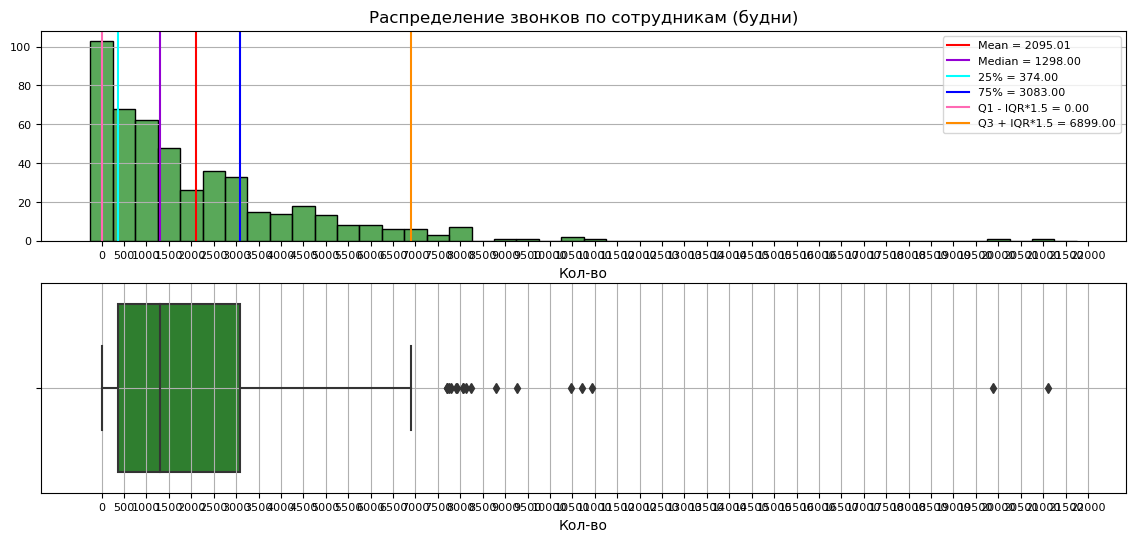

In [25]:
data = call_pivot['calls_weekday_sum'].astype(int)
plot_dist(data, title='Распределение звонков по сотрудникам (будни)', xlabel='Кол-во', binstep=500)

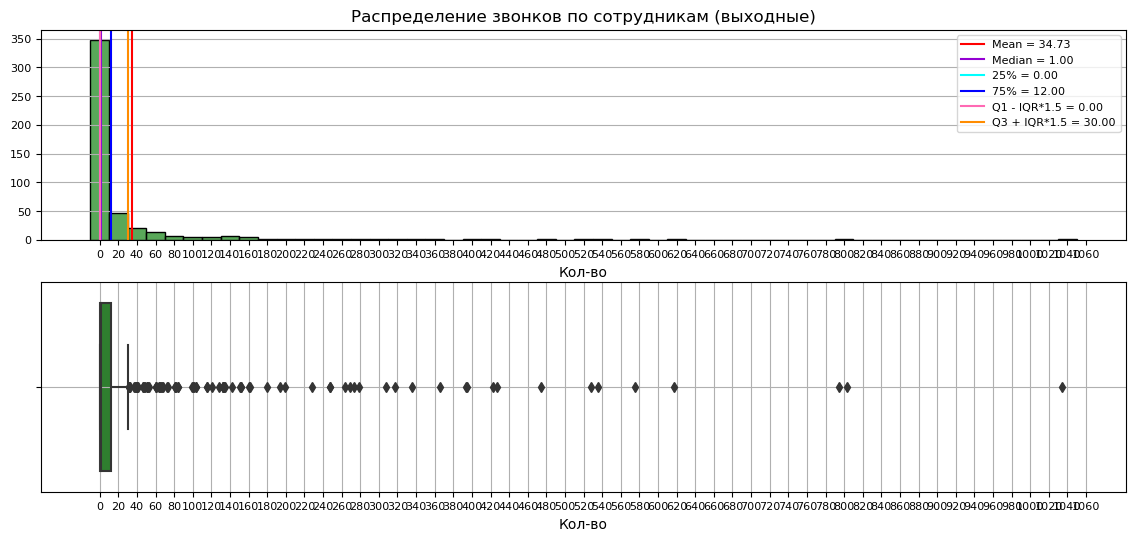

In [26]:
data = call_pivot['calls_weekend_sum'].astype(int)
plot_dist(data, title='Распределение звонков по сотрудникам (выходные)', xlabel='Кол-во', binstep=20)

In [27]:
call_pivot_time = pd.pivot_table(df_calls[['id', 'Weekday', 'CallTime']], index='id', columns='Weekday', aggfunc=sum, fill_value=0)
call_pivot_time.columns = call_pivot_time.columns.droplevel(0)
call_pivot_time = call_pivot_time.rename_axis(None, axis=1)
call_pivot_time = call_pivot_time.rename(columns={'Будни': 'time_calls_weekday_sum', 'Выходные дни': 'time_calls_weekend_sum'})
call_pivot_time

time_calls_weekday_sum  time_calls_weekend_sum
id                                                        
ОРГ1-00057               46.627222                0.000000
ОРГ1-00085               82.242500                0.036667
ОРГ1-00100               23.197222                0.000000
ОРГ1-00125               22.082222                0.000000
ОРГ1-00147                6.021944                0.000000
...                            ...                     ...
ОРГ2-05140               48.083056                0.000000
ОРГ2-05211               15.066389                0.000000
ОРГ2-05295               19.382500                0.000000
ОРГ2-05862                0.310833                0.000000
ОРГ2-06006                0.220278                0.000000

[481 rows x 2 columns]

In [28]:
print((call_pivot['calls_weekday_sum'] > 0).value_counts())
print((call_pivot_time['time_calls_weekday_sum'] > 0).value_counts())

True     480
False      1
Name: calls_weekday_sum, dtype: int64
True     473
False      8
Name: time_calls_weekday_sum, dtype: int64


In [29]:
print((call_pivot['calls_weekend_sum'] > 0).value_counts())
print((call_pivot_time['time_calls_weekend_sum'] > 0).value_counts())

True     248
False    233
Name: calls_weekend_sum, dtype: int64
False    265
True     216
Name: time_calls_weekend_sum, dtype: int64


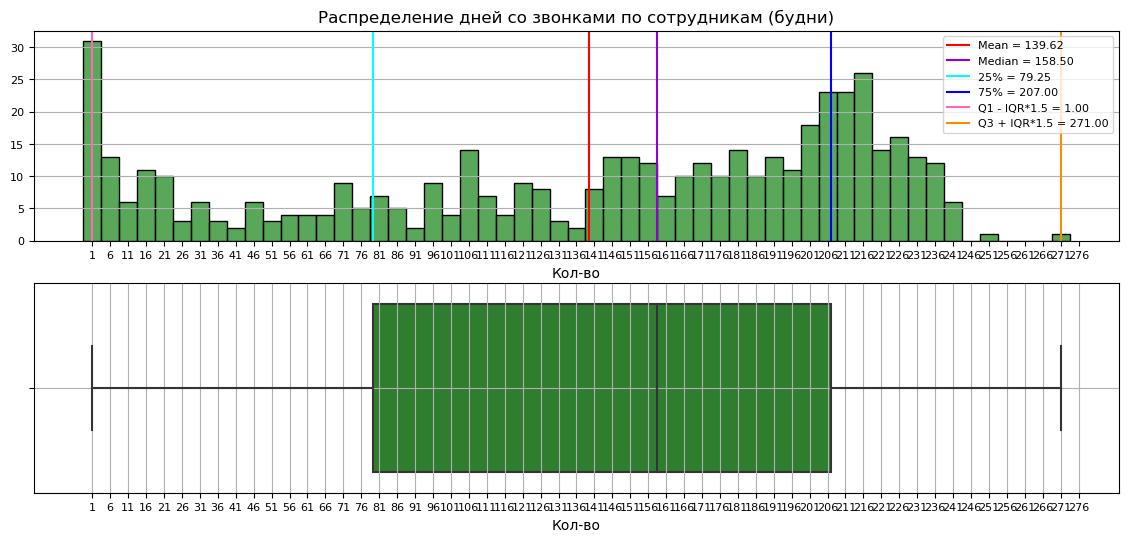

In [30]:
df_calls_days_weekday = df_calls[df_calls['Weekday'] == 'Будни'].drop_duplicates(['Date', 'id'])
df_calls_days_weekday = df_calls_days_weekday.groupby('id')['Date'].agg('count')
# df_calls_days_weekday

plot_dist(df_calls_days_weekday, title='Распределение дней со звонками по сотрудникам (будни)', xlabel='Кол-во', binstep=5)

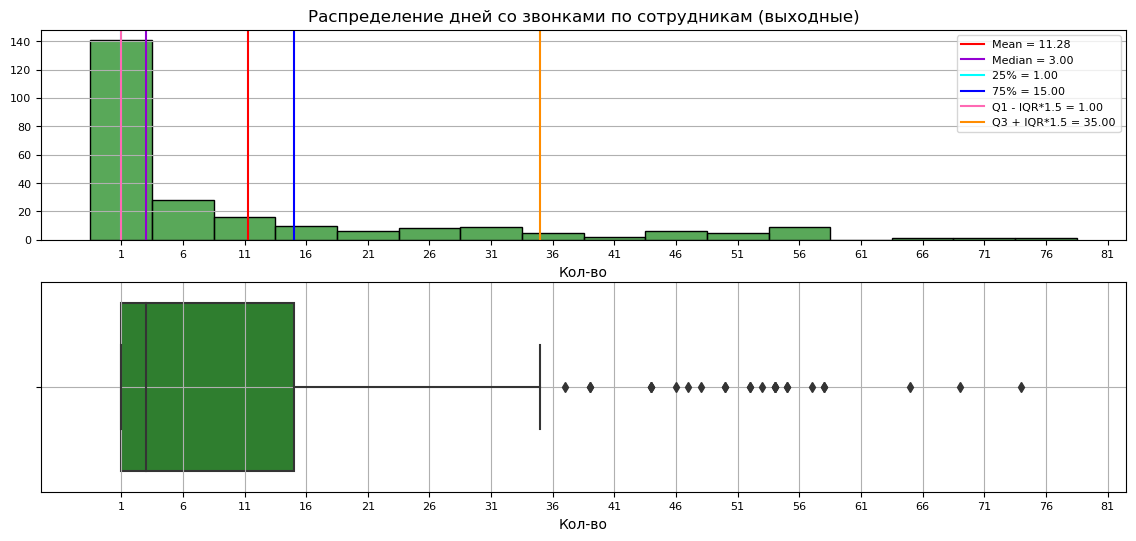

In [31]:
df_calls_days_weekend = df_calls[df_calls['Weekday'] == 'Выходные дни'].drop_duplicates(['Date', 'id'])
df_calls_days_weekend = df_calls_days_weekend.groupby('id')['Date'].agg('count')
# df_calls_days_weekend

plot_dist(df_calls_days_weekend, title='Распределение дней со звонками по сотрудникам (выходные)', xlabel='Кол-во', binstep=5)

In [32]:
df_calls_days_weekday = df_calls_days_weekday.reset_index()
df_calls_days_weekday = df_calls_days_weekday.rename(columns={'Date': 'call_weekday_count'})
df_calls_days_weekend = df_calls_days_weekend.reset_index()
df_calls_days_weekend = df_calls_days_weekend.rename(columns={'Date': 'call_weekend_count'})

In [33]:
call_pivot = pd.merge(call_pivot.reset_index(), call_pivot_time.reset_index(), on="id", how='left').drop_duplicates(subset="id").fillna(0)
call_pivot = pd.merge(call_pivot, df_calls_days_weekday, on="id", how='left').drop_duplicates(subset="id").fillna(0)
call_pivot = pd.merge(call_pivot, df_calls_days_weekend, on="id", how='left').drop_duplicates(subset="id").fillna(0)
call_pivot['time_calls_weekday_mean'] = call_pivot['time_calls_weekday_sum'] / call_pivot['call_weekday_count']
call_pivot['time_calls_weekend_mean'] = call_pivot['time_calls_weekend_sum'] / call_pivot['call_weekend_count']

### ConnectionTime - определение опозданий по данным

In [34]:
df_connection_time = remove_unused_id(df_connection_time)

before: 230662
after: 110396


In [35]:
df_connection_time.head(3)

dateNum                maxLogOff  \
3  2021-12-15 00:00:00,000  2021-12-15 20:35:14,833   
6  2021-12-15 00:00:00,000  2021-12-16 00:03:00,040   
9  2021-12-15 00:00:00,000  2021-12-15 17:36:48,376   

  Нормативное время начала раб.дня Фактич. время начала раб.дня  \
3          1899-12-30 08:30:00,000      1899-12-30 08:28:43,956   
6          1899-12-30 08:30:00,000      1899-12-30 00:03:53,360   
9          1899-12-30 08:30:00,000      1899-12-30 08:10:33,770   

   Время опоздания Признак опоздания Вых/Будни          id  
3              NaN               NaN     Будни  ОРГ1-00254  
6              NaN               NaN     Будни  ОРГ1-02725  
9              NaN               NaN     Будни  ОРГ1-00753

In [36]:
df_connection_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110396 entries, 3 to 230660
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   dateNum                           110396 non-null  object 
 1   maxLogOff                         110396 non-null  object 
 2   Нормативное время начала раб.дня  110396 non-null  object 
 3   Фактич. время начала раб.дня      110396 non-null  object 
 4   Время опоздания                   46131 non-null   float64
 5   Признак опоздания                 33652 non-null   object 
 6   Вых/Будни                         110396 non-null  object 
 7   id                                110396 non-null  object 
dtypes: float64(1), object(7)
memory usage: 7.6+ MB


In [37]:
missing_values_table(df_connection_time, ascending=False)

Пропущенные значения  % Пропущенных значений
Признак опоздания                 76744                  69.517
Время опоздания                   64265                  58.213

In [38]:
df_connection_time[df_connection_time.duplicated()].sort_values('Время опоздания')

dateNum                maxLogOff  \
129603  2021-07-07 00:00:00,000  2021-07-07 18:10:55,516   
129300  2021-07-05 00:00:00,000  2021-07-05 18:16:00,286   
129024  2021-09-10 00:00:00,000  2021-09-10 12:00:41,606   
129376  2021-07-15 00:00:00,000  2021-07-15 14:15:38,543   
129605  2021-10-08 00:00:00,000  2021-10-08 18:11:28,003   
...                         ...                      ...   
126973  2021-09-09 00:00:00,000  2021-09-09 18:13:59,866   
126975  2021-10-05 00:00:00,000  2021-10-05 18:23:01,456   
126977  2021-11-09 00:00:00,000  2021-11-09 17:23:17,870   
126979  2021-12-02 00:00:00,000  2021-12-02 19:37:03,833   
126981  2021-12-08 00:00:00,000  2021-12-08 18:05:19,700   

       Нормативное время начала раб.дня Фактич. время начала раб.дня  \
129603          1899-12-30 09:00:00,000      1899-12-30 09:00:02,486   
129300          1899-12-30 09:00:00,000      1899-12-30 09:00:03,020   
129024          1899-12-30 09:00:00,000      1899-12-30 09:00:06,183   
129376          1899-12-30 09:00:00,000      1899-12-30 09:00:06,630   
129605          1899-12-30 09:00:00,000      1899-12-30 09:00:14,303   
...                                 ...                          ...   
126973          1899-12-30 09:00:00,000      1899-12-30 08:53:01,926   
126975          1899-12-30 09:00:00,000      1899-12-30 08:56:39,390   
126977          1899-12-30 09:00:00,000      1899-12-30 08:57:10,716   
126979          1899-12-30 09:00:00,000      1899-12-30 08:53:03,683   
126981          1899-12-30 09:00:00,000      1899-12-30 08:59:19,846   

        Время опоздания Признак опоздания Вых/Будни          id  
129603         0.000691               NaN     Будни  ОРГ1-00763  
129300         0.000839               NaN     Будни  ОРГ1-00763  
129024         0.001717               NaN     Будни  ОРГ1-00763  
129376         0.001842               NaN     Будни  ОРГ1-00763  
129605         0.003973               NaN     Будни  ОРГ1-00763  
...                 ...               ...       ...         ...  
126973              NaN               NaN     Будни  ОРГ1-00763  
126975              NaN               NaN     Будни  ОРГ1-00763  
126977              NaN               NaN     Будни  ОРГ1-00763  
126979              NaN               NaN     Будни  ОРГ1-00763  
126981              NaN               NaN     Будни  ОРГ1-00763  

[235 rows x 8 columns]

In [39]:
df_connection_time[df_connection_time.duplicated()].value_counts('id')

id
ОРГ1-00763    235
dtype: int64

In [40]:
df_connection_time[df_connection_time['id']=='ОРГ1-00763'].shape

(470, 8)

In [41]:
df_connection_time = df_connection_time.drop_duplicates(keep='first')
df_connection_time.shape

(110161, 8)

In [42]:
df_connection_time = df_connection_time.drop_duplicates(subset=['id', 'dateNum'], keep='first')
df_connection_time.shape

(87247, 8)

In [43]:
df_connection_time[df_connection_time['Признак опоздания'].notna()].value_counts('Признак опоздания')

Признак опоздания
Опоздание    18329
dtype: int64

In [44]:
df_connection_time[df_connection_time['Признак опоздания'].notna()].sort_values(['Время опоздания'])

dateNum                maxLogOff  \
195224  2021-09-14 00:00:00,000  2021-09-14 16:51:09,900   
206097  2021-10-18 00:00:00,000  2021-10-18 15:05:56,786   
205109  2021-11-12 00:00:00,000  2021-11-12 17:31:04,056   
187240  2021-10-11 00:00:00,000  2021-10-11 17:25:54,430   
215456  2021-12-01 00:00:00,000  2021-12-01 18:31:24,383   
...                         ...                      ...   
142959  2021-11-14 00:00:00,000  2021-11-14 23:57:28,650   
186216  2021-07-14 00:00:00,000  2021-07-15 00:01:05,466   
139278  2021-12-25 00:00:00,000  2021-12-26 00:01:44,186   
214876  2021-12-06 00:00:00,000  2021-12-07 00:02:09,040   
141366  2021-10-17 00:00:00,000  2021-10-18 00:04:51,846   

       Нормативное время начала раб.дня Фактич. время начала раб.дня  \
195224          1899-12-30 08:30:00,000      1899-12-30 08:40:00,076   
206097          1899-12-30 08:30:00,000      1899-12-30 08:40:00,080   
205109          1899-12-30 08:30:00,000      1899-12-30 08:40:00,146   
187240          1899-12-30 08:30:00,000      1899-12-30 08:40:00,183   
215456          1899-12-30 08:30:00,000      1899-12-30 08:40:00,486   
...                                 ...                          ...   
142959          1899-12-30 08:30:00,000      1899-12-30 23:52:28,650   
186216          1899-12-30 08:30:00,000      1899-12-30 23:56:05,466   
139278          1899-12-30 08:30:00,000      1899-12-30 23:56:44,186   
214876          1899-12-30 08:30:00,000      1899-12-30 23:57:09,040   
141366          1899-12-30 08:30:00,000      1899-12-30 23:59:51,846   

        Время опоздания Признак опоздания     Вых/Будни          id  
195224         0.166688         Опоздание         Будни  ОРГ1-01464  
206097         0.166689         Опоздание         Будни  ОРГ1-02672  
205109         0.166707         Опоздание         Будни  ОРГ1-00980  
187240         0.166717         Опоздание         Будни  ОРГ1-02931  
215456         0.166802         Опоздание         Будни  ОРГ2-04903  
...                 ...               ...           ...         ...  
142959        15.374625         Опоздание  Выходные дни  ОРГ1-02823  
186216        15.434852         Опоздание         Будни  ОРГ1-01805  
139278        15.445607         Опоздание  Выходные дни  ОРГ1-01489  
214876        15.452511         Опоздание         Будни  ОРГ2-02524  
141366        15.497735         Опоздание  Выходные дни  ОРГ1-00666  

[18329 rows x 8 columns]

In [45]:
df_connection_time[df_connection_time['Признак опоздания'].isna() & df_connection_time['Время опоздания'].notna()].sort_values(['Время опоздания'])

dateNum                maxLogOff  \
146336  2021-07-01 00:00:00,000  2021-07-01 17:30:55,030   
165461  2021-12-06 00:00:00,000  2021-12-06 20:51:13,110   
146062  2021-10-01 00:00:00,000  2021-10-01 16:30:51,366   
150768  2021-07-19 00:00:00,000  2021-07-19 17:16:22,740   
156887  2021-10-26 00:00:00,000  2021-10-26 17:21:13,100   
...                         ...                      ...   
156229  2021-10-12 00:00:00,000  2021-10-12 16:46:20,670   
147158  2021-08-26 00:00:00,000  2021-08-26 17:46:46,803   
162851  2021-11-19 00:00:00,000  2021-11-19 17:26:10,143   
148472  2021-06-22 00:00:00,000  2021-06-22 18:13:29,743   
156476  2021-08-19 00:00:00,000  2021-08-19 17:30:58,813   

       Нормативное время начала раб.дня Фактич. время начала раб.дня  \
146336          1899-12-30 08:30:00,000      1899-12-30 08:30:00,046   
165461          1899-12-30 08:30:00,000      1899-12-30 08:30:00,080   
146062          1899-12-30 08:30:00,000      1899-12-30 08:30:00,093   
150768          1899-12-30 08:30:00,000      1899-12-30 08:30:00,096   
156887          1899-12-30 08:30:00,000      1899-12-30 08:30:00,130   
...                                 ...                          ...   
156229          1899-12-30 08:30:00,000      1899-12-30 08:39:59,753   
147158          1899-12-30 08:30:00,000      1899-12-30 08:39:59,763   
162851          1899-12-30 08:30:00,000      1899-12-30 08:39:59,766   
148472          1899-12-30 08:30:00,000      1899-12-30 08:39:59,816   
156476          1899-12-30 08:30:00,000      1899-12-30 08:39:59,990   

        Время опоздания Признак опоздания Вых/Будни          id  
146336         0.000013               NaN     Будни  ОРГ1-02626  
165461         0.000022               NaN     Будни  ОРГ2-00515  
146062         0.000026               NaN     Будни  ОРГ1-01758  
150768         0.000027               NaN     Будни  ОРГ1-01802  
156887         0.000036               NaN     Будни  ОРГ2-04850  
...                 ...               ...       ...         ...  
156229         0.166598               NaN     Будни  ОРГ1-02672  
147158         0.166601               NaN     Будни  ОРГ1-02106  
162851         0.166602               NaN     Будни  ОРГ1-00057  
148472         0.166616               NaN     Будни  ОРГ1-00677  
156476         0.166664               NaN     Будни  ОРГ1-01776  

[10876 rows x 8 columns]

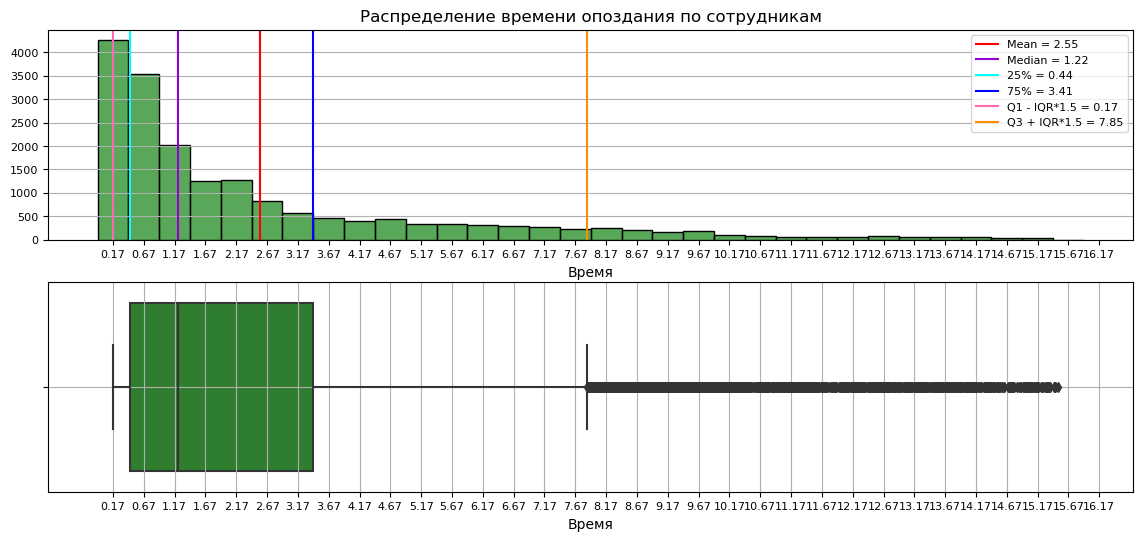

In [46]:
data = df_connection_time[df_connection_time['Признак опоздания'].notna()]['Время опоздания']
plot_dist(data, title='Распределение времени опоздания по сотрудникам', xlabel='Время', binstep=0.5)

In [47]:
df_connection_time = df_connection_time[df_connection_time['Время опоздания'] < 8]

In [48]:
df_connection_time['Время опоздания'] = df_connection_time['Время опоздания'].fillna(0)
df_connection_time['Признак опоздания'] = df_connection_time['Признак опоздания'].apply(lambda x: 1 if x=='Опоздание' else 0)

df_connection_time['Признак задержки'] = df_connection_time['Время опоздания'].apply(lambda x: 1 if x<0.166676 and x>0 else 0)
df_connection_time['Признак прогула'] = df_connection_time['Время опоздания'].apply(lambda x: 1 if x>4.0 else 0)


df_connection_time['Время задержки'] = df_connection_time['Время опоздания'].apply(lambda x: x if x<0.166676 and x>0 else 0)
df_connection_time['Время прогула'] = df_connection_time['Время опоздания'].apply(lambda x: x if x>4.0 else 0)
df_connection_time['Время опоздания'] = df_connection_time['Время опоздания'].apply(lambda x: x if (x<4.0 and x>0.166676) else 0)

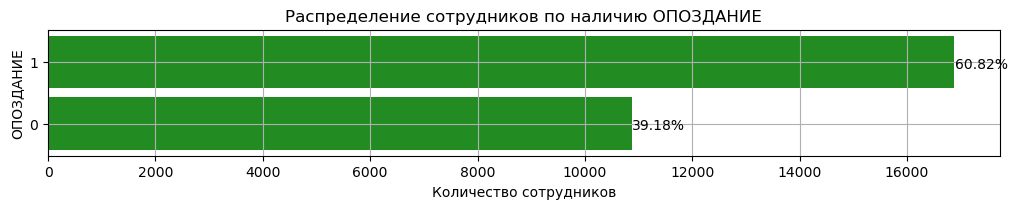

In [49]:
plot_barh(data = df_connection_time,
    x='id', y='Признак опоздания',
    title='Распределение сотрудников по наличию ОПОЗДАНИЕ',
    x_axis='Количество сотрудников', y_axis='ОПОЗДАНИЕ', color=MAIN_COLOR)

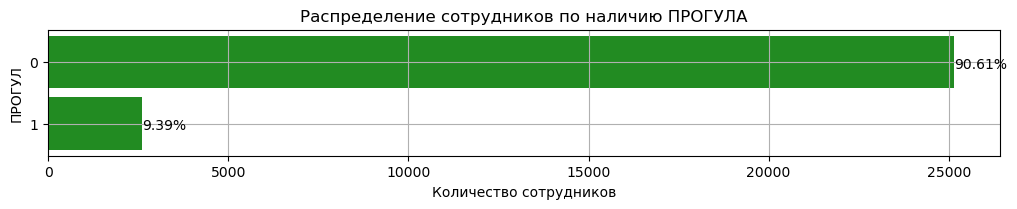

In [50]:
plot_barh(data = df_connection_time,
    x='id', y='Признак прогула',
    title='Распределение сотрудников по наличию ПРОГУЛА',
    x_axis='Количество сотрудников', y_axis='ПРОГУЛ', color=MAIN_COLOR)

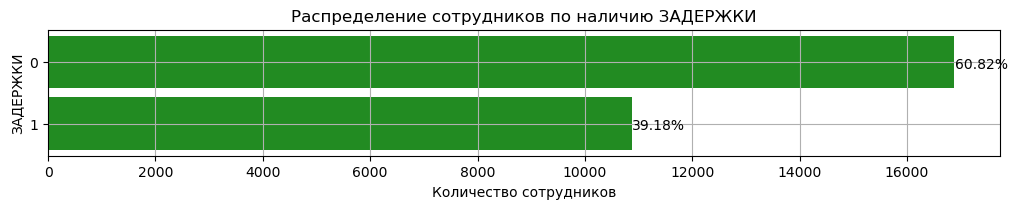

In [51]:
plot_barh(data = df_connection_time,
    x='id', y='Признак задержки',
    title='Распределение сотрудников по наличию ЗАДЕРЖКИ',
    x_axis='Количество сотрудников', y_axis='ЗАДЕРЖКИ', color=MAIN_COLOR)

In [52]:
df_connection_time = df_connection_time.rename(columns={'Время опоздания': 'time_late',
                                                        'Признак опоздания': 'is_late',
                                                        'Время задержки': 'time_delay',
                                                        'Признак задержки': 'is_delay',
                                                        'Время прогула': 'time_hooky',
                                                        'Признак прогула': 'is_hooky',
                                                        })
df_connection_time.head(3)

dateNum                maxLogOff  \
127561  2021-12-28 00:00:00,000  2021-12-28 19:46:18,170   
127562  2021-06-21 00:00:00,000  2021-06-21 19:54:16,216   
127563  2021-06-24 00:00:00,000  2021-06-24 18:33:14,566   

       Нормативное время начала раб.дня Фактич. время начала раб.дня  \
127561          1899-12-30 09:30:00,000      1899-12-30 13:20:36,600   
127562          1899-12-30 09:30:00,000      1899-12-30 11:43:20,683   
127563          1899-12-30 09:30:00,000      1899-12-30 15:42:54,673   

        time_late  is_late Вых/Будни          id  is_delay  is_hooky  \
127561   3.843500        1     Будни  ОРГ1-01589         0         0   
127562   2.222412        1     Будни  ОРГ1-01589         0         0   
127563   0.000000        1     Будни  ОРГ1-01589         0         1   

        time_delay  time_hooky  
127561         0.0    0.000000  
127562         0.0    0.000000  
127563         0.0    6.215187

In [53]:
df_connection_time_agg = df_connection_time.groupby('id').agg({'dateNum': ['count'],
                                                            'is_delay': ['sum', 'mean'],
                                                            'is_late': ['sum', 'mean', 'last'],
                                                            'is_hooky': ['sum', 'mean', 'last'],
                                                            'time_delay': ['sum', 'mean'],
                                                            'time_late': ['sum', 'mean'],
                                                            'time_hooky': ['sum', 'mean']})
df_connection_time_agg.columns = ['_'.join(col).strip() for col in df_connection_time_agg.columns.values]
df_connection_time_agg

dateNum_count  is_delay_sum  is_delay_mean  is_late_sum  \
id                                                                    
ОРГ1-00057             24            21       0.875000            3   
ОРГ1-00085              8             0       0.000000            8   
ОРГ1-00100              3             0       0.000000            3   
ОРГ1-00125             38            26       0.684211           12   
ОРГ1-00148             17             5       0.294118           12   
...                   ...           ...            ...          ...   
ОРГ2-07748              1             0       0.000000            1   
ОРГ2-07791              8             4       0.500000            4   
ОРГ2-07861              3             2       0.666667            1   
ОРГ2-07862              3             2       0.666667            1   
ОРГ2-07924              9             4       0.444444            5   

            is_late_mean  is_late_last  is_hooky_sum  is_hooky_mean  \
id                                                                    
ОРГ1-00057      0.125000             1             1       0.041667   
ОРГ1-00085      1.000000             1             4       0.500000   
ОРГ1-00100      1.000000             1             2       0.666667   
ОРГ1-00125      0.315789             1             1       0.026316   
ОРГ1-00148      0.705882             1             4       0.235294   
...                  ...           ...           ...            ...   
ОРГ2-07748      1.000000             1             1       1.000000   
ОРГ2-07791      0.500000             1             1       0.125000   
ОРГ2-07861      0.333333             1             0       0.000000   
ОРГ2-07862      0.333333             1             0       0.000000   
ОРГ2-07924      0.555556             1             0       0.000000   

            is_hooky_last  time_delay_sum  time_delay_mean  time_late_sum  \
id                                                                          
ОРГ1-00057              0        1.193336         0.049722       2.944434   
ОРГ1-00085              1        0.000000         0.000000      10.600967   
ОРГ1-00100              1        0.000000         0.000000       1.490541   
ОРГ1-00125              0        2.040590         0.053700       5.582991   
ОРГ1-00148              0        0.221131         0.013008      19.068780   
...                   ...             ...              ...            ...   
ОРГ2-07748              1        0.000000         0.000000       0.000000   
ОРГ2-07791              0        0.295483         0.036935       3.521677   
ОРГ2-07861              0        0.224863         0.074954       2.618044   
ОРГ2-07862              0        0.041818         0.013939       2.778034   
ОРГ2-07924              0        0.412294         0.045810       6.090424   

            time_late_mean  time_hooky_sum  time_hooky_mean  
id                                                           
ОРГ1-00057        0.122685        4.445455         0.185227  
ОРГ1-00085        1.325121       20.226311         2.528289  
ОРГ1-00100        0.496847        9.472766         3.157589  
ОРГ1-00125        0.146921        4.565306         0.120140  
ОРГ1-00148        1.121693       23.031231         1.354778  
...                    ...             ...              ...  
ОРГ2-07748        0.000000        5.062229         5.062229  
ОРГ2-07791        0.440210        7.909536         0.988692  
ОРГ2-07861        0.872681        0.000000         0.000000  
ОРГ2-07862        0.926011        0.000000         0.000000  
ОРГ2-07924        0.676714        0.000000         0.000000  

[719 rows x 15 columns]

In [54]:
df = pd.merge(df_train, df_connection_time_agg, on="id", how='left')
missing_values_table(df, ascending=False)

Пропущенные значения  % Пропущенных значений
dateNum_count                      61                  11.091
is_delay_sum                       61                  11.091
is_delay_mean                      61                  11.091
is_late_sum                        61                  11.091
is_late_mean                       61                  11.091
is_late_last                       61                  11.091
is_hooky_sum                       61                  11.091
is_hooky_mean                      61                  11.091
is_hooky_last                      61                  11.091
time_delay_sum                     61                  11.091
time_delay_mean                    61                  11.091
time_late_sum                      61                  11.091
time_late_mean                     61                  11.091
time_hooky_sum                     61                  11.091
time_hooky_mean                    61                  11.091

In [55]:
df = pd.merge(df_test, df_connection_time_agg, on="id", how='left')
missing_values_table(df, ascending=False)

Пропущенные значения  % Пропущенных значений
dateNum_count                      32                  12.214
is_delay_sum                       32                  12.214
is_delay_mean                      32                  12.214
is_late_sum                        32                  12.214
is_late_mean                       32                  12.214
is_late_last                       32                  12.214
is_hooky_sum                       32                  12.214
is_hooky_mean                      32                  12.214
is_hooky_last                      32                  12.214
time_delay_sum                     32                  12.214
time_delay_mean                    32                  12.214
time_late_sum                      32                  12.214
time_late_mean                     32                  12.214
time_hooky_sum                     32                  12.214
time_hooky_mean                    32                  12.214

### Education - образование

In [56]:
df_ed.head(3)

Табельный номер руководителя          id  \
0                          NaN  ОРГ1-00131   
1                          NaN  ОРГ1-03220   
2                          NaN  ОРГ1-03008   

                        Вид образования  Специальность  
0      Высшее образование - бакалавриат  Юриспруденция  
1  Среднее профессиональное образование        Финансы  
2                    Высшее образование  Юриспруденция

In [57]:
df_ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5609 entries, 0 to 5608
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Табельный номер руководителя  3380 non-null   object
 1   id                            5609 non-null   object
 2   Вид образования               5510 non-null   object
 3   Специальность                 4852 non-null   object
dtypes: object(4)
memory usage: 175.4+ KB


In [58]:
missing_values_table(df_ed, ascending=False)

Пропущенные значения  % Пропущенных значений
Табельный номер руководителя                  2229                  39.740
Специальность                                  757                  13.496
Вид образования                                 99                   1.765

In [59]:
df_ed[df_ed.duplicated()].sort_values('id')['Вид образования'].value_counts()

Повышение квалификации                    95
Высшее образование                         3
Начальное профессиональное образование     1
Name: Вид образования, dtype: int64

In [60]:
df_ed = df_ed.drop_duplicates()

In [61]:
df_ed[df_ed[['id']].duplicated(keep=False)].shape == df_ed[df_ed[['id', 'Табельный номер руководителя']].duplicated(keep=False)].shape

True

In [62]:
df_ed[df_ed['id'].duplicated()].sort_values('id')['Вид образования'].value_counts()

Повышение квалификации                            278
Высшее образование                                186
Высшее образование - специалитет, магистратура     82
Переподготовка                                     43
Высшее образование - бакалавриат                   40
Среднее профессиональное образование               15
Аспирантура                                         6
Начальное профессиональное образование              3
Среднее общее образование                           1
Name: Вид образования, dtype: int64

In [63]:
ttt = df_ed[(df_ed['Вид образования'] == 'Высшее образование') | (df_ed['Вид образования'] == 'Высшее образование - бакалавриат')]
ttt[ttt[['id', 'Специальность']].duplicated()].sort_values('id')['Вид образования'].value_counts()

Высшее образование    8
Name: Вид образования, dtype: int64

In [64]:
ttt = df_ed[(df_ed['Вид образования'] == 'Высшее образование') | (df_ed['Вид образования'] == 'Высшее образование - специалитет, магистратура')]
ttt[ttt[['id', 'Специальность']].duplicated()].sort_values('id')['Вид образования'].value_counts()

Высшее образование - специалитет, магистратура    2
Name: Вид образования, dtype: int64

In [65]:
ttt = df_ed[(df_ed['Вид образования'] == 'Высшее образование - бакалавриат') | (df_ed['Вид образования'] == 'Высшее образование - специалитет, магистратура')]
ttt[ttt[['id', 'Специальность']].duplicated()].sort_values('id')['Вид образования'].value_counts()

Высшее образование - специалитет, магистратура    34
Name: Вид образования, dtype: int64

In [66]:
df_ed['education'] = df_ed['Вид образования'].copy()

In [67]:
dict_edu = {
    'Высшее образование': 'edu_high',
    'Высшее образование - бакалавриат': 'edu_high',
    'Высшее образование - специалитет, магистратура': 'edu_high',
    'Неполное высшее образование': 'edu_high',
    'Среднее (полное) общее образование': 'edu_middle',
    'Среднее общее образование': 'edu_middle',
    'Основное общее образование': 'edu_middle',
    'Повышение квалификации': 'edu_training',
    'Переподготовка': 'edu_training',
    'Послевузовское образование': 'edu_training',
    'Послевузовское образование': 'edu_training',
    'Дополнительное профессиональное образование': 'edu_training',
    'Среднее профессиональное образование': 'edu_middle_prof',
    'Начальное профессиональное образование': 'edu_primary_prof',
    'Профессиональное обучение': 'edu_training',
    'Аспирантура': 'edu_phd',
    'Начальное общее образование': 'edu_primary',
}

df_ed['Вид образования'] = df_ed['Вид образования'].apply(lambda x: dict_edu[x] if x in dict_edu else x)

In [68]:
df_ed[df_ed['id'].duplicated()].sort_values('id')['Вид образования'].value_counts()

edu_training        321
edu_high            308
edu_middle_prof      15
edu_phd               6
edu_primary_prof      3
edu_middle            1
Name: Вид образования, dtype: int64

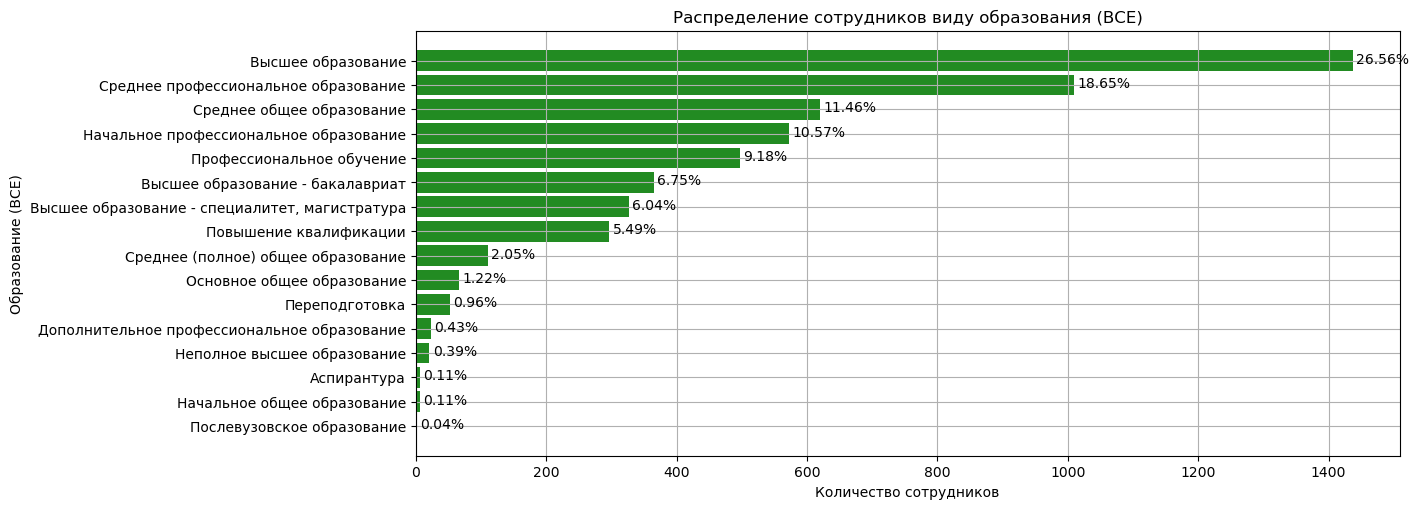

In [69]:
plot_barh(data = df_ed,
    x='id', y='education',
    title='Распределение сотрудников виду образования (ВСЕ)',
    x_axis='Количество сотрудников', y_axis='Образование (ВСЕ)', color=MAIN_COLOR, figsize=(14,5))

edu_high            2150
edu_middle_prof     1009
edu_training         871
edu_middle           797
edu_primary_prof     572
edu_phd                6
edu_primary            6
Name: Вид образования, dtype: int64


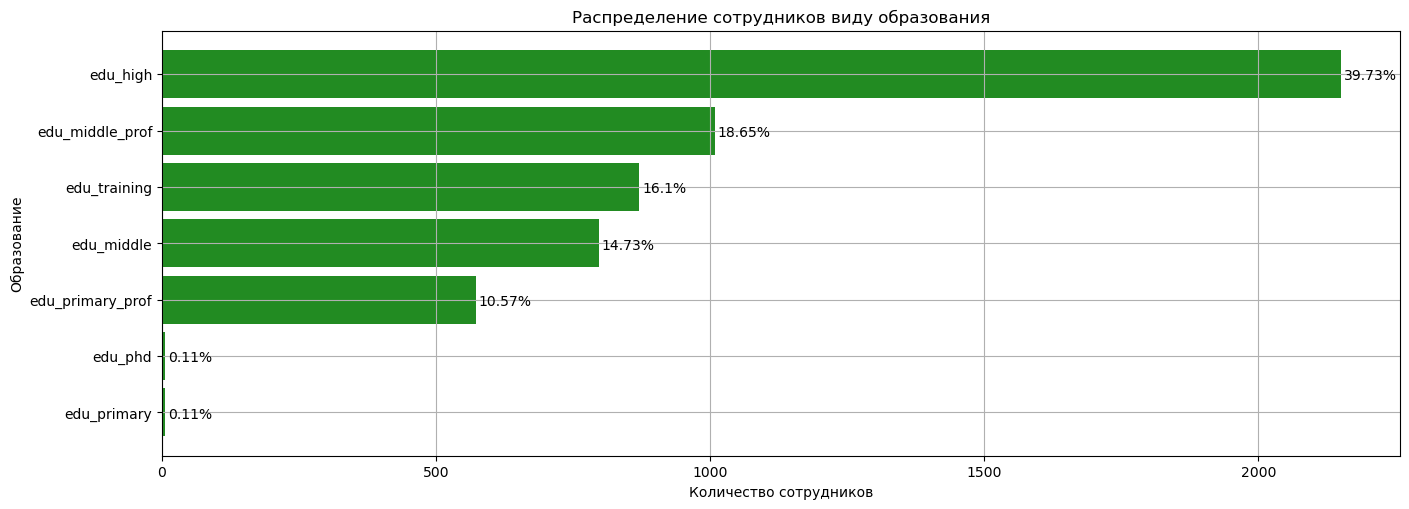

In [70]:
print(df_ed['Вид образования'].value_counts())

plot_barh(data = df_ed,
    x='id', y='Вид образования',
    title='Распределение сотрудников виду образования',
    x_axis='Количество сотрудников', y_axis='Образование', color=MAIN_COLOR, figsize=(14,5))

In [71]:
edu_pivot = pd.pivot_table(df_ed[['id', 'Вид образования', 'Специальность']], index='id', columns='Вид образования', aggfunc='count', fill_value=0)
edu_pivot.columns = edu_pivot.columns.droplevel(0)
edu_pivot = edu_pivot.rename_axis(None, axis=1)
edu_pivot['edu_high'] = edu_pivot['edu_high'].apply(lambda x: 2 if x>2 else x)
edu_pivot

edu_high  edu_middle  edu_middle_prof  edu_phd  edu_primary  \
id                                                                        
ОРГ1-00001         1           0                0        0            0   
ОРГ1-00004         1           0                0        0            0   
ОРГ1-00005         1           0                0        0            0   
ОРГ1-00010         1           0                0        0            0   
ОРГ1-00013         2           0                0        0            0   
...              ...         ...              ...      ...          ...   
ОРГ2-09282         1           0                0        0            0   
ОРГ2-09283         1           0                0        0            0   
ОРГ2-09284         0           0                0        0            0   
ОРГ2-09285         1           0                0        0            0   
ОРГ2-09286         1           0                0        0            0   

            edu_primary_prof  edu_training  
id                                          
ОРГ1-00001                 0             2  
ОРГ1-00004                 0             2  
ОРГ1-00005                 0             5  
ОРГ1-00010                 0             0  
ОРГ1-00013                 0             0  
...                      ...           ...  
ОРГ2-09282                 0             0  
ОРГ2-09283                 0             0  
ОРГ2-09284                 1             0  
ОРГ2-09285                 0             0  
ОРГ2-09286                 0             0  

[4759 rows x 7 columns]

In [72]:
df_ed['Табельный номер руководителя'] = df_ed['Табельный номер руководителя'].fillna(0)
df_ed['has_boss'] = df_ed['Табельный номер руководителя'].apply(lambda x: 1 if x else 0)
df_ed['has_boss'].value_counts()

1    3300
0    2209
Name: has_boss, dtype: int64

In [73]:
has_sub = df_ed.groupby('Табельный номер руководителя')['id'].agg('count').reset_index()
has_sub = has_sub.rename(columns={'id': 'count_subords', 'Табельный номер руководителя': 'id'})
has_sub['has_sub'] = has_sub['count_subords'].apply(lambda x: 1 if x>0 else 0)
has_sub

id  count_subords  has_sub
0             0           2209        1
1    ОРГ1-00004              5        1
2    ОРГ1-00005             11        1
3    ОРГ1-00044             20        1
4    ОРГ1-00046              2        1
..          ...            ...      ...
148  ОРГ2-05327              2        1
149  ОРГ2-06006              4        1
150  ОРГ2-06329              3        1
151  ОРГ2-09100           1797        1
152  ОРГ2-09266              7        1

[153 rows x 3 columns]

In [74]:
# df_ed = df_ed.rename(columns={'Вид образования': 'education'})
df_ed = df_ed[['id', 'education', 'has_boss']]

In [75]:
df = pd.merge(df_train, df_ed, on="id", how='left')
missing_values_table(df, ascending=False)

Пропущенные значения  % Пропущенных значений
education                    87                  11.523
has_boss                     71                   9.404

In [76]:
df = pd.merge(df_test, df_ed, on="id", how='left')
missing_values_table(df, ascending=False)

Пропущенные значения  % Пропущенных значений
education                    47                  13.239
has_boss                     38                  10.704

In [77]:
df = pd.merge(df_train, has_sub, on="id", how='left')
missing_values_table(df, ascending=False)

Пропущенные значения  % Пропущенных значений
count_subords                   511                  92.909
has_sub                         511                  92.909

In [78]:
df = pd.merge(df_test, has_sub, on="id", how='left')
missing_values_table(df, ascending=False)

Пропущенные значения  % Пропущенных значений
count_subords                   244                   93.13
has_sub                         244                   93.13

In [79]:
df = pd.merge(df_train, edu_pivot, on="id", how='left')
missing_values_table(df, ascending=False)

Пропущенные значения  % Пропущенных значений
edu_high                            71                  12.909
edu_middle                          71                  12.909
edu_middle_prof                     71                  12.909
edu_phd                             71                  12.909
edu_primary                         71                  12.909
edu_primary_prof                    71                  12.909
edu_training                        71                  12.909

In [80]:
df = pd.merge(df_test, edu_pivot, on="id", how='left')
missing_values_table(df, ascending=False)

Пропущенные значения  % Пропущенных значений
edu_high                            38                  14.504
edu_middle                          38                  14.504
edu_middle_prof                     38                  14.504
edu_phd                             38                  14.504
edu_primary                         38                  14.504
edu_primary_prof                    38                  14.504
edu_training                        38                  14.504

### Tasks - данные о исполнении задач

In [81]:
df_tasks = remove_unused_id(df_tasks)

before: 536660
after: 237067


In [82]:
df_tasks.head(3)

Статус по просрочке Срок плановый  Просрочено, дней ДлительностьПросрочки  \
0  Без нарушения срока           NaN                 0   без нарушения срока   
1  Без нарушения срока           NaN                 0   без нарушения срока   
2  Без нарушения срока           NaN                 0   без нарушения срока   

                              ID задачи      Вид документа  \
0  E1DE844D-EE2D-4C41-AEDF-93F246749F0E  Служебная записка   
1  7A92343C-8C9A-46E7-AC81-8F50F95009D0  Служебная записка   
2  5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0  Служебная записка   

       Дата старта задания Дата завершения задания плановая  \
0  2021-12-10 00:00:00,000                              NaN   
1  2021-12-10 00:00:00,000                              NaN   
2  2021-12-10 00:00:00,000                              NaN   

  Дата завершения задания фактическая Состояние задания          id  
0             2021-12-10 00:00:00,000         Завершено  ОРГ1-02588  
1             2021-12-10 00:00:00,000         Завершено  ОРГ1-02588  
2             2021-12-10 00:00:00,000         Завершено  ОРГ1-02588

In [83]:
df_tasks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237067 entries, 0 to 521810
Data columns (total 11 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   Статус по просрочке                  237067 non-null  object
 1   Срок плановый                        5596 non-null    object
 2   Просрочено, дней                     237067 non-null  int64 
 3   ДлительностьПросрочки                237067 non-null  object
 4   ID задачи                            237067 non-null  object
 5   Вид документа                        235791 non-null  object
 6   Дата старта задания                  237067 non-null  object
 7   Дата завершения задания плановая     118065 non-null  object
 8   Дата завершения задания фактическая  231322 non-null  object
 9   Состояние задания                    237067 non-null  object
 10  id                                   237067 non-null  object
dtypes: int64(1), object(10)
me

In [84]:
missing_values_table(df_tasks)

Пропущенные значения  \
Статус по просрочке                                     0   
Срок плановый                                      231471   
Просрочено, дней                                        0   
ДлительностьПросрочки                                   0   
ID задачи                                               0   
Вид документа                                        1276   
Дата старта задания                                     0   
Дата завершения задания плановая                   119002   
Дата завершения задания фактическая                  5745   
Состояние задания                                       0   
id                                                      0   

                                     % Пропущенных значений  
Статус по просрочке                                   0.000  
Срок плановый                                        97.639  
Просрочено, дней                                      0.000  
ДлительностьПросрочки                                 0.000  
ID задачи                                             0.000  
Вид документа                                         0.538  
Дата старта задания                                   0.000  
Дата завершения задания плановая                     50.198  
Дата завершения задания фактическая                   2.423  
Состояние задания                                     0.000  
id                                                    0.000

In [85]:
df_tasks[df_tasks.duplicated()].sort_values('id')['Статус по просрочке'].value_counts()

Series([], Name: Статус по просрочке, dtype: int64)

In [86]:
df_tasks[df_tasks[['id', 'ID задачи']].duplicated()].sort_values('id')['Статус по просрочке'].value_counts()

Series([], Name: Статус по просрочке, dtype: int64)

Без нарушения срока    202796
С нарушением срока      34271
Name: Статус по просрочке, dtype: int64


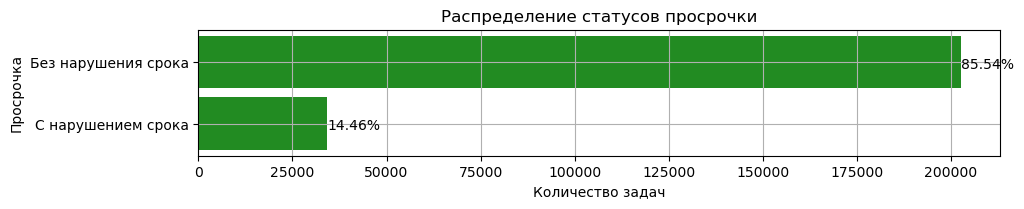

In [87]:
print(df_tasks['Статус по просрочке'].value_counts())

plot_barh(data = df_tasks,
    x='id', y='Статус по просрочке',
    title='Распределение статусов просрочки',
    x_axis='Количество задач', y_axis='Просрочка', color=MAIN_COLOR)

In [88]:
df_tasks.head(1)

Статус по просрочке Срок плановый  Просрочено, дней ДлительностьПросрочки  \
0  Без нарушения срока           NaN                 0   без нарушения срока   

                              ID задачи      Вид документа  \
0  E1DE844D-EE2D-4C41-AEDF-93F246749F0E  Служебная записка   

       Дата старта задания Дата завершения задания плановая  \
0  2021-12-10 00:00:00,000                              NaN   

  Дата завершения задания фактическая Состояние задания          id  
0             2021-12-10 00:00:00,000         Завершено  ОРГ1-02588

без нарушения срока    202796
более 30 дней           14520
до 7 дней               12992
до 30 дней               6759
Name: ДлительностьПросрочки, dtype: int64


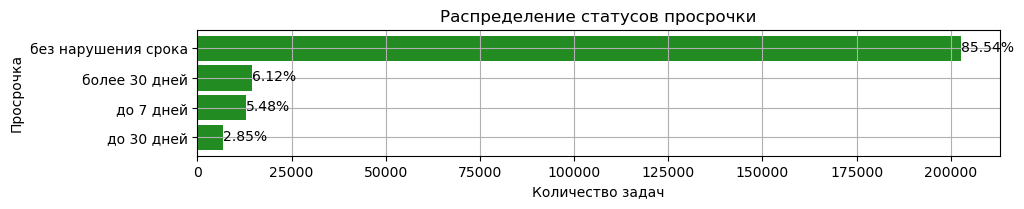

In [89]:
print(df_tasks['ДлительностьПросрочки'].value_counts())

plot_barh(data = df_tasks,
    x='id', y='ДлительностьПросрочки',
    title='Распределение статусов просрочки',
    x_axis='Количество задач', y_axis='Просрочка', color=MAIN_COLOR)

Завершено                  231440
Не начато                    3412
В работе                     1938
Делегировано                  214
На приёмке                     31
Отложено                       27
Возврат с делегирования         5
Name: Состояние задания, dtype: int64


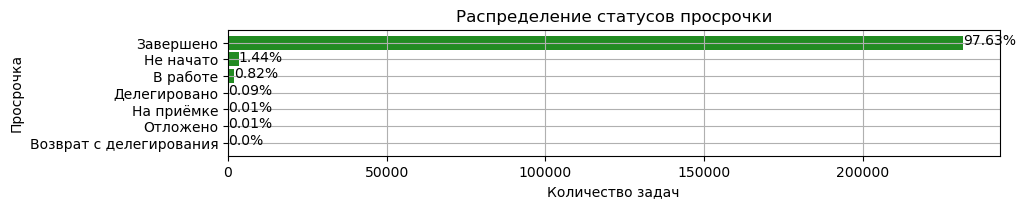

In [90]:
print(df_tasks['Состояние задания'].value_counts())

plot_barh(data = df_tasks,
    x='id', y='Состояние задания',
    title='Распределение статусов просрочки',
    x_axis='Количество задач', y_axis='Просрочка', color=MAIN_COLOR)

Служебная записка                              103630
Входящий                                        33158
Исходящий                                       21628
Приказ                                          19606
Внутренний документ                             16545
Дополнительное соглашение                       11952
Договор                                         11871
Акт                                              8629
Файл                                             2673
Распоряжение                                     2574
Протокол                                         1590
Исходящий РМЗ                                    1343
Запрос на внесение изменений                      221
Внутренний документ для БП синхронизация 1С       199
Отчет по ВА                                       172
Name: Вид документа, dtype: int64


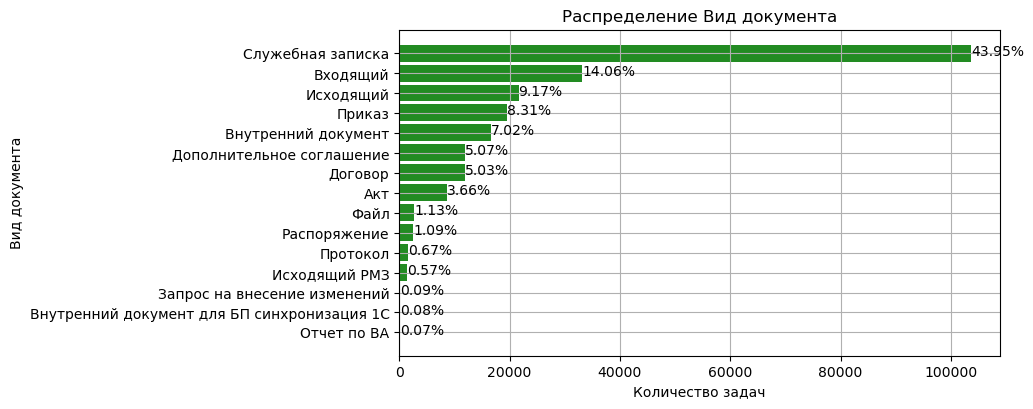

In [91]:
print(df_tasks['Вид документа'].value_counts())

plot_barh(data = df_tasks,
    x='id', y='Вид документа',
    title='Распределение Вид документа',
    x_axis='Количество задач', y_axis='Вид документа', color=MAIN_COLOR, figsize=(10,4))

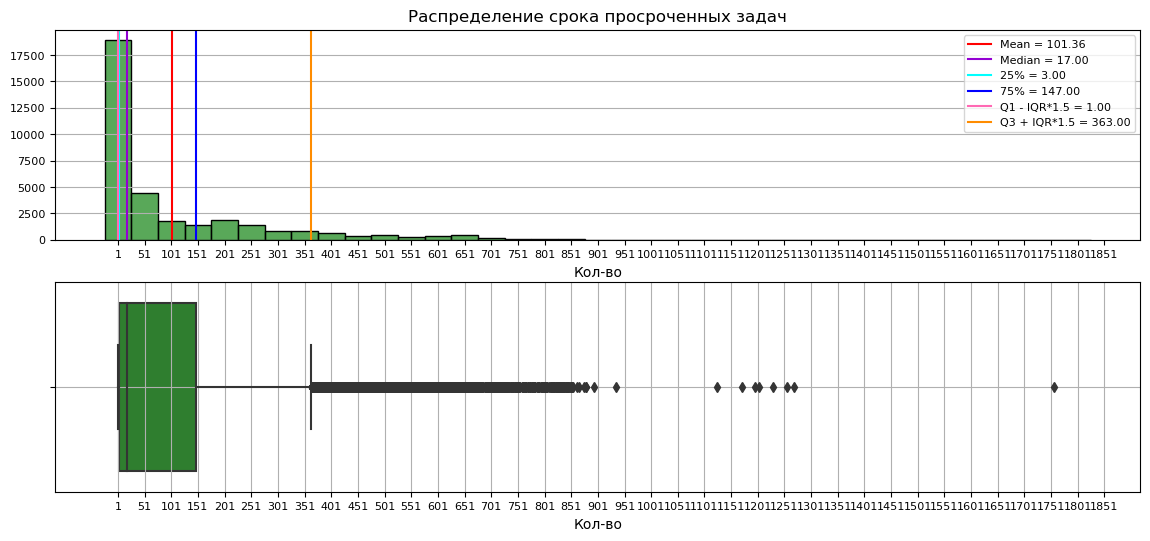

In [92]:
data = df_tasks[df_tasks['Просрочено, дней'] != 0]['Просрочено, дней']
plot_dist(data, title='Распределение срока просроченных задач', xlabel='Кол-во', binstep=50)

In [93]:
df_tasks = df_tasks.rename(columns={'Просрочено, дней': 'task_wasted_days',
                                    'ДлительностьПросрочки': 'task_wasted_cat',
                                    'Состояние задания': 'task_status',
                                    })

df_tasks_wasted_agg = df_tasks[df_tasks['task_wasted_days'] > 0].groupby('id').agg({'task_wasted_days': ['sum', 'mean', 'count']})
df_tasks_wasted_agg.columns = ['_'.join(col).strip() for col in df_tasks_wasted_agg.columns.values]
df_tasks_wasted_agg

task_wasted_days_sum  task_wasted_days_mean  \
id                                                        
ОРГ1-00057                    85               6.538462   
ОРГ1-00081                 29227             495.372881   
ОРГ1-00085                   383              22.529412   
ОРГ1-00100                    46               9.200000   
ОРГ1-00148                    85               6.071429   
...                          ...                    ...   
ОРГ2-05859                  3874             203.894737   
ОРГ2-05862                 12615              25.079523   
ОРГ2-05934                  1158              34.058824   
ОРГ2-06006                   308               6.695652   
ОРГ2-06061                    79               3.590909   

            task_wasted_days_count  
id                                  
ОРГ1-00057                      13  
ОРГ1-00081                      59  
ОРГ1-00085                      17  
ОРГ1-00100                       5  
ОРГ1-00148                      14  
...                            ...  
ОРГ2-05859                      19  
ОРГ2-05862                     503  
ОРГ2-05934                      34  
ОРГ2-06006                      46  
ОРГ2-06061                      22  

[554 rows x 3 columns]

In [94]:
df_tasks_agg = df_tasks.groupby('id').agg({'task_status': ['count']})
df_tasks_agg.columns = ['task_count']
df_tasks_agg

task_count
id                    
ОРГ1-00057         122
ОРГ1-00081          62
ОРГ1-00085         177
ОРГ1-00100          99
ОРГ1-00125           2
...                ...
ОРГ2-05859          20
ОРГ2-05862        2054
ОРГ2-05934          52
ОРГ2-06006         395
ОРГ2-06061         108

[594 rows x 1 columns]

In [95]:
df_tasks_agg = pd.merge(df_tasks_agg.reset_index(), df_tasks_wasted_agg.reset_index(), on="id", how='left').drop_duplicates(subset="id").fillna(0)
df_tasks_agg = df_tasks_agg.rename(columns={'task_wasted_days_count': 'task_wasted_count'})
df_tasks_agg['task_wasted_fraction'] = df_tasks_agg['task_wasted_count'] / df_tasks_agg['task_count']
df_tasks_agg

id  task_count  task_wasted_days_sum  task_wasted_days_mean  \
0    ОРГ1-00057         122                  85.0               6.538462   
1    ОРГ1-00081          62               29227.0             495.372881   
2    ОРГ1-00085         177                 383.0              22.529412   
3    ОРГ1-00100          99                  46.0               9.200000   
4    ОРГ1-00125           2                   0.0               0.000000   
..          ...         ...                   ...                    ...   
589  ОРГ2-05859          20                3874.0             203.894737   
590  ОРГ2-05862        2054               12615.0              25.079523   
591  ОРГ2-05934          52                1158.0              34.058824   
592  ОРГ2-06006         395                 308.0               6.695652   
593  ОРГ2-06061         108                  79.0               3.590909   

     task_wasted_count  task_wasted_fraction  
0                 13.0              0.106557  
1                 59.0              0.951613  
2                 17.0              0.096045  
3                  5.0              0.050505  
4                  0.0              0.000000  
..                 ...                   ...  
589               19.0              0.950000  
590              503.0              0.244888  
591               34.0              0.653846  
592               46.0              0.116456  
593               22.0              0.203704  

[594 rows x 6 columns]

### SKUD - приход / уход сотрудников

In [96]:
df_skud = remove_unused_id(df_skud)

before: 22580
after: 8079


In [97]:
df_skud.head(3)

Дата                 Приход.1                   Уход.1  \
0  2021-03-01 00:00:00,000  1899-12-30 08:11:00,000  1899-12-30 17:32:00,000   
2  2021-03-01 00:00:00,000  1899-12-30 08:31:00,000  1899-12-30 17:32:00,000   
3  2021-03-01 00:00:00,000  1899-12-30 08:31:00,000  1899-12-30 17:32:00,000   

   Длительность общая  Длительность раб.дня без обеда Вых/Будни          id  
0            9.350000                        8.350000     Будни  ОРГ1-00791  
2            9.016667                        8.016667     Будни  ОРГ1-00713  
3            9.016667                        8.016667     Будни  ОРГ1-02127

In [98]:
df_skud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8079 entries, 0 to 22578
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Дата                            8079 non-null   object 
 1   Приход.1                        8079 non-null   object 
 2   Уход.1                          8079 non-null   object 
 3   Длительность общая              8079 non-null   float64
 4   Длительность раб.дня без обеда  8079 non-null   float64
 5   Вых/Будни                       8079 non-null   object 
 6   id                              8079 non-null   object 
dtypes: float64(2), object(5)
memory usage: 504.9+ KB


In [99]:
df_skud[df_skud.duplicated()].sort_values('id')['Дата'].value_counts()

Series([], Name: Дата, dtype: int64)

In [100]:
df_skud[df_skud[['Дата', 'id']].duplicated()].sort_values('id')['id'].value_counts()

ОРГ1-01388    32
ОРГ1-00148    31
ОРГ1-02705    31
ОРГ1-00150    29
ОРГ1-01779    29
ОРГ1-00125    27
ОРГ1-00222    27
ОРГ1-01780    22
ОРГ1-00515    15
ОРГ1-00870    14
ОРГ1-01169     8
ОРГ1-02694     7
Name: id, dtype: int64

In [101]:
df_skud = df_skud.drop_duplicates(subset=['Дата', 'id'])

In [102]:
skud_pivot_time = pd.pivot_table(df_skud[['id', 'Вых/Будни', 'Длительность раб.дня без обеда']], index='id', columns='Вых/Будни', aggfunc=(sum, np.mean), fill_value=0)
skud_pivot_time.columns = skud_pivot_time.columns.droplevel(0)
skud_pivot_time.columns = skud_pivot_time.columns.droplevel(0)
skud_pivot_time.columns = ['skud_weekday_mean', 'skud_weekend_mean', 'skud_weekday_sum', 'skud_weekend_sum']
skud_pivot_time

skud_weekday_mean  skud_weekend_mean  skud_weekday_sum  \
id                                                                   
ОРГ1-00057           8.834409           0.000000        273.866667   
ОРГ1-00085           8.658333           4.233333        277.066667   
ОРГ1-00089           8.423958           0.000000        269.566667   
ОРГ1-00100          10.069231           7.450000        130.900000   
ОРГ1-00125           8.700000           0.000000        278.400000   
...                       ...                ...               ...   
ОРГ1-02750           7.450000           0.000000         14.900000   
ОРГ1-02755           5.883333           0.000000          5.883333   
ОРГ1-02798           8.914583           0.000000        285.266667   
ОРГ1-02884           9.151562           0.000000        292.850000   
ОРГ1-02903           5.207895           0.000000         98.950000   

            skud_weekend_sum  
id                            
ОРГ1-00057          0.000000  
ОРГ1-00085          4.233333  
ОРГ1-00089          0.000000  
ОРГ1-00100          7.450000  
ОРГ1-00125          0.000000  
...                      ...  
ОРГ1-02750          0.000000  
ОРГ1-02755          0.000000  
ОРГ1-02798          0.000000  
ОРГ1-02884          0.000000  
ОРГ1-02903          0.000000  

[304 rows x 4 columns]

### TimenNetwork - общее время активности пользователя в сети

In [103]:
df_timen = remove_unused_id(df_timen)

before: 216110
after: 106614


In [104]:
df_timen.head(3)

Вых/Будни  monitor_Time                startTime          id
148     Будни           300  2021-06-22 00:00:00,000  ОРГ1-01497
149     Будни           300  2021-06-24 00:00:00,000  ОРГ1-01497
150     Будни           300  2021-06-24 00:00:00,000  ОРГ1-01497

In [105]:
df_timen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106614 entries, 148 to 216108
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Вых/Будни     106614 non-null  object
 1   monitor_Time  106614 non-null  int64 
 2   startTime     106614 non-null  object
 3   id            106614 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.1+ MB


In [106]:
# df_timen[df_timen.duplicated()].sort_values('id')['startTime'].value_counts()

In [107]:
# df_timen = df_timen.drop_duplicates()

In [108]:
timen_pivot_time = pd.pivot_table(df_timen[['id', 'Вых/Будни', 'monitor_Time']], index='id', columns='Вых/Будни', aggfunc=(sum, np.mean), fill_value=0)
timen_pivot_time.columns = timen_pivot_time.columns.droplevel(0)
timen_pivot_time.columns = timen_pivot_time.columns.droplevel(0)
timen_pivot_time.columns = ['timen_weekday_mean', 'timen_weekend_mean', 'timen_weekday_sum', 'timen_weekend_sum']
timen_pivot_time

timen_weekday_mean  timen_weekend_mean  timen_weekday_sum  \
id                                                                      
ОРГ1-00057        16799.067797          300.000000            1982290   
ОРГ1-00085        23099.766234         6602.181818            3557364   
ОРГ1-00089        18459.269663            0.000000            1642875   
ОРГ1-00100        28495.436508            0.000000            3590425   
ОРГ1-00125        18745.157303            0.000000            1668319   
...                        ...                 ...                ...   
ОРГ2-06001         9134.448819          300.500000            1160075   
ОРГ2-06006        25964.871212         4801.666667            3427363   
ОРГ2-06061        33484.458015            0.000000            4386464   
ОРГ2-06062         1837.080808         1941.823529             181871   
ОРГ2-06122         4270.768657         8304.333333             572283   

            timen_weekend_sum  
id                             
ОРГ1-00057                300  
ОРГ1-00085              72624  
ОРГ1-00089                  0  
ОРГ1-00100                  0  
ОРГ1-00125                  0  
...                       ...  
ОРГ2-06001                601  
ОРГ2-06006              14405  
ОРГ2-06061                  0  
ОРГ2-06062              33011  
ОРГ2-06122              74739  

[712 rows x 4 columns]

### WorkingDay - активное время в сети

In [109]:
df_work = remove_unused_id(df_work)

before: 1971927
after: 985061


In [110]:
df_work.head(3)

startTime  activeTime Вых/Будни  monitorTime          id
1  2021-11-30 00:00:00,000           2     Будни            2  ОРГ1-02112
2  2021-11-30 00:00:00,000           2     Будни            2  ОРГ1-02112
3  2021-11-30 00:00:00,000           2     Будни            2  ОРГ1-01846

In [111]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985061 entries, 1 to 1971882
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   startTime    985061 non-null  object
 1   activeTime   985061 non-null  int64 
 2   Вых/Будни    985061 non-null  object
 3   monitorTime  985061 non-null  int64 
 4   id           985061 non-null  object
dtypes: int64(2), object(3)
memory usage: 45.1+ MB


In [112]:
work_pivot_time = pd.pivot_table(df_work[['id', 'Вых/Будни', 'activeTime']], index='id', columns='Вых/Будни', aggfunc=(sum, np.mean), fill_value=0)
work_pivot_time.columns = work_pivot_time.columns.droplevel(0)
work_pivot_time.columns = work_pivot_time.columns.droplevel(0)
work_pivot_time.columns = ['work_weekday_mean', 'work_weekend_mean', 'work_weekday_sum', 'work_weekend_sum']
work_pivot_time

work_weekday_mean  work_weekend_mean  work_weekday_sum  \
id                                                                   
ОРГ1-00057        1298.736684          19.333333           1731216   
ОРГ1-00085        1353.707505         591.000000           2994401   
ОРГ1-00089        1205.865289           0.000000           1459097   
ОРГ1-00100        1457.765576           7.317073           3252275   
ОРГ1-00125        1383.014720           0.000000           1409292   
...                       ...                ...               ...   
ОРГ2-06001        1224.297974          36.375000           1027186   
ОРГ2-06006        2210.241692         490.777778           2926360   
ОРГ2-06061        2929.309186          66.555556           3922345   
ОРГ2-06062         419.986264         478.109091            152875   
ОРГ2-06122         538.505131         878.055556            472269   

            work_weekend_sum  
id                            
ОРГ1-00057               116  
ОРГ1-00085             57918  
ОРГ1-00089                 0  
ОРГ1-00100               300  
ОРГ1-00125                 0  
...                      ...  
ОРГ2-06001               291  
ОРГ2-06006             13251  
ОРГ2-06061               599  
ОРГ2-06062             26296  
ОРГ2-06122             63220  

[713 rows x 4 columns]

## Add features

In [113]:
pd.merge(df_full, edu_pivot[['edu_phd', 'edu_primary']], on="id", how='left').drop_duplicates(subset="id").fillna(0).sum()

id             ОРГ1-02649ОРГ2-05929ОРГ2-05859ОРГ1-00279ОРГ2-0...
type                                                         745
edu_phd                                                      2.0
edu_primary                                                  0.0
dtype: object

In [114]:
pd.merge(df_test, edu_pivot[['edu_phd', 'edu_primary']], on="id", how='left').drop_duplicates(subset="id").fillna(0).sum()

id             ОРГ1-02649ОРГ2-05929ОРГ2-05859ОРГ1-00279ОРГ2-0...
type                                                           0
edu_phd                                                      2.0
edu_primary                                                  0.0
dtype: object

In [115]:
edu_pivot = edu_pivot.drop(['edu_phd', 'edu_primary'], axis=1)

In [116]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df = pd.merge(df, call_pivot, on="id", how='left').drop_duplicates(subset="id").fillna(0)
    df = pd.merge(df, df_connection_time_agg, on="id", how='left').drop_duplicates(subset="id").fillna(0) # TODO
    df = pd.merge(df, edu_pivot, on="id", how='left').drop_duplicates(subset="id").fillna(0)
    df = pd.merge(df, df_ed, on="id", how='left').drop_duplicates(subset="id")
    df['education'] = df['education'].fillna('undef')
    df['has_boss'] = df['has_boss'].fillna(0)
    df = pd.merge(df, has_sub, on="id", how='left').drop_duplicates(subset="id").fillna(0)
    df = pd.merge(df, df_tasks_agg, on="id", how='left').drop_duplicates(subset="id").fillna(0)
    df = pd.merge(df, df_org, on="id", how='left').drop_duplicates(subset="id")
    df = pd.merge(df, skud_pivot_time, on="id", how='left').drop_duplicates(subset="id").fillna(0)
    df = pd.merge(df, timen_pivot_time, on="id", how='left').drop_duplicates(subset="id").fillna(0)
    df = pd.merge(df, work_pivot_time, on="id", how='left').drop_duplicates(subset="id").fillna(0)

    return df

### Train

In [117]:
df_train = add_features(df_train)
df_train

id  type  calls_weekday_sum  calls_weekend_sum  \
0    ОРГ1-02050     2              546.0                0.0   
1    ОРГ1-02783     2             1902.0                0.0   
2    ОРГ2-06173     0                0.0                0.0   
3    ОРГ2-05359     2                0.0                0.0   
4    ОРГ1-00803     2                7.0                0.0   
..          ...   ...                ...                ...   
545  ОРГ1-02587     2                0.0                0.0   
546  ОРГ1-02383     2             4234.0              336.0   
547  ОРГ1-02862     2                0.0                0.0   
548  ОРГ1-00471     2             3638.0              279.0   
549  ОРГ2-02694     2                3.0                0.0   

     time_calls_weekday_sum  time_calls_weekend_sum  call_weekday_count  \
0                 20.615000                0.000000                69.0   
1                 44.835556                0.000000               138.0   
2                  0.000000                0.000000                 0.0   
3                  0.000000                0.000000                 0.0   
4                  0.032500                0.000000                 3.0   
..                      ...                     ...                 ...   
545                0.000000                0.000000                 0.0   
546              173.336111                6.711111               202.0   
547                0.000000                0.000000                 0.0   
548              129.696389                5.269444               190.0   
549                1.535556                0.000000                 2.0   

     call_weekend_count  time_calls_weekday_mean  time_calls_weekend_mean  \
0                   0.0                 0.298768                 0.000000   
1                   0.0                 0.324895                 0.000000   
2                   0.0                 0.000000                 0.000000   
3                   0.0                 0.000000                 0.000000   
4                   0.0                 0.010833                 0.000000   
..                  ...                      ...                      ...   
545                 0.0                 0.000000                 0.000000   
546                58.0                 0.858100                 0.115709   
547                 0.0                 0.000000                 0.000000   
548                34.0                 0.682613                 0.154984   
549                 0.0                 0.767778                 0.000000   

     dateNum_count  is_delay_sum  is_delay_mean  is_late_sum  is_late_mean  \
0              7.0           3.0       0.428571          4.0      0.571429   
1              7.0           4.0       0.571429          3.0      0.428571   
2             14.0           7.0       0.500000          7.0      0.500000   
3              6.0           0.0       0.000000          6.0      1.000000   
4             29.0           0.0       0.000000         29.0      1.000000   
..             ...           ...            ...          ...           ...   
545            0.0           0.0       0.000000          0.0      0.000000   
546           29.0          12.0       0.413793         17.0      0.586207   
547            0.0           0.0       0.000000          0.0      0.000000   
548           16.0           4.0       0.250000         12.0      0.750000   
549            0.0           0.0       0.000000          0.0      0.000000   

     is_late_last  is_hooky_sum  is_hooky_mean  is_hooky_last  time_delay_sum  \
0             1.0           1.0       0.142857            0.0        0.042881   
1             1.0           1.0       0.142857            0.0        0.091828   
2             1.0           4.0       0.285714            1.0        0.511503   
3             1.0           3.0       0.500000            1.0        0.000000   
4             1.0           8.0       0.275862            1.0        0.000000   
..     

In [118]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       550 non-null    object 
 1   type                     550 non-null    int64  
 2   calls_weekday_sum        550 non-null    float64
 3   calls_weekend_sum        550 non-null    float64
 4   time_calls_weekday_sum   550 non-null    float64
 5   time_calls_weekend_sum   550 non-null    float64
 6   call_weekday_count       550 non-null    float64
 7   call_weekend_count       550 non-null    float64
 8   time_calls_weekday_mean  550 non-null    float64
 9   time_calls_weekend_mean  550 non-null    float64
 10  dateNum_count            550 non-null    float64
 11  is_delay_sum             550 non-null    float64
 12  is_delay_mean            550 non-null    float64
 13  is_late_sum              550 non-null    float64
 14  is_late_mean             5

In [119]:
df_train.describe()

type  calls_weekday_sum  calls_weekend_sum  \
count  550.000000         550.000000         550.000000   
mean     1.354545        1252.910909          20.103636   
std      0.936863        2220.306714          83.731302   
min      0.000000           0.000000           0.000000   
25%      0.000000           0.000000           0.000000   
50%      2.000000         126.500000           0.000000   
75%      2.000000        1722.000000           2.000000   
max      3.000000       21106.000000        1034.000000   

       time_calls_weekday_sum  time_calls_weekend_sum  call_weekday_count  \
count              550.000000              550.000000          550.000000   
mean                38.493822                0.516075           82.901818   
std                 68.974629                2.308612           90.667296   
min                  0.000000                0.000000            0.000000   
25%                  0.000000                0.000000            0.000000   
50%                  4.773472                0.000000           28.500000   
75%                 51.049861                0.010625          180.000000   
max                663.740000               34.016944          271.000000   

       call_weekend_count  time_calls_weekday_mean  time_calls_weekend_mean  \
count          550.000000               550.000000               550.000000   
mean             3.365455                 0.236141                 0.052521   
std             10.434246                 0.341068                 0.178136   
min              0.000000                 0.000000                 0.000000   
25%              0.000000                 0.000000                 0.000000   
50%              0.000000                 0.118387                 0.000000   
75%              1.000000                 0.321317                 0.003542   
max             69.000000                 2.765583                 2.006389   

       dateNum_count  is_delay_sum  is_delay_mean  is_late_sum  is_late_mean  \
count     550.000000    550.000000     550.000000   550.000000    550.000000   
mean       33.672727     13.450909       0.333512    20.221818      0.555579   
std        32.607091     16.792540       0.283136    25.141166      0.323790   
min         0.000000      0.000000       0.000000     0.000000      0.000000   
25%         8.000000      1.000000       0.054645     4.000000      0.310345   
50%        24.000000      6.000000       0.291796    12.000000      0.575758   
75%        50.000000     21.000000       0.577778    25.000000      0.844740   
max       153.000000     83.000000       1.000000   153.000000      1.000000   

       is_late_last  is_hooky_sum  is_hooky_mean  is_hooky_last  \
count    550.000000    550.000000     550.000000     550.000000   
mean       0.880000      3.152727       0.120185       0.158182   
std        0.325257      4.294524       0.150397       0.365244   
min        0.000000      0.000000       0.000000       0.000000   
25%        1.000000      0.000000       0.000000       0.000000   
50%        1.000000      2.000000       0.071429       0.000000   
75%        1.000000      4.000000       0.165816       0.000000   
max        1.000000     49.000000       1.000000       1.000000   

       time_delay_sum  time_delay_mean  time_late_sum  time_late_mean  \
count      550.000000       550.000000     550.000000      550.000000   
mean         0.888183         0.020488      19.929353        0.561550   
std          1.200138         0.017573      32.035356        0.474898   
min          0.000000         0.000000       0.000000        0.000000   
25%          0.039550         0.002737       3.502769        0.209566   
50%          0.415153         0.019578      11.261790        0.446865   
75%          1.220798         0.034542      22.786219        0.823569   
max          6.758410         0.081485     291.047443        2.709515   

       time_hooky_sum  time_hooky_mean    edu_high  edu_middle  \
count      550.000000     

In [120]:
df_train["education"].astype('category').cat.codes.value_counts()

1     297
0      73
11     64
2      59
3      30
4       7
7       7
5       5
10      3
9       2
6       2
8       1
dtype: int64

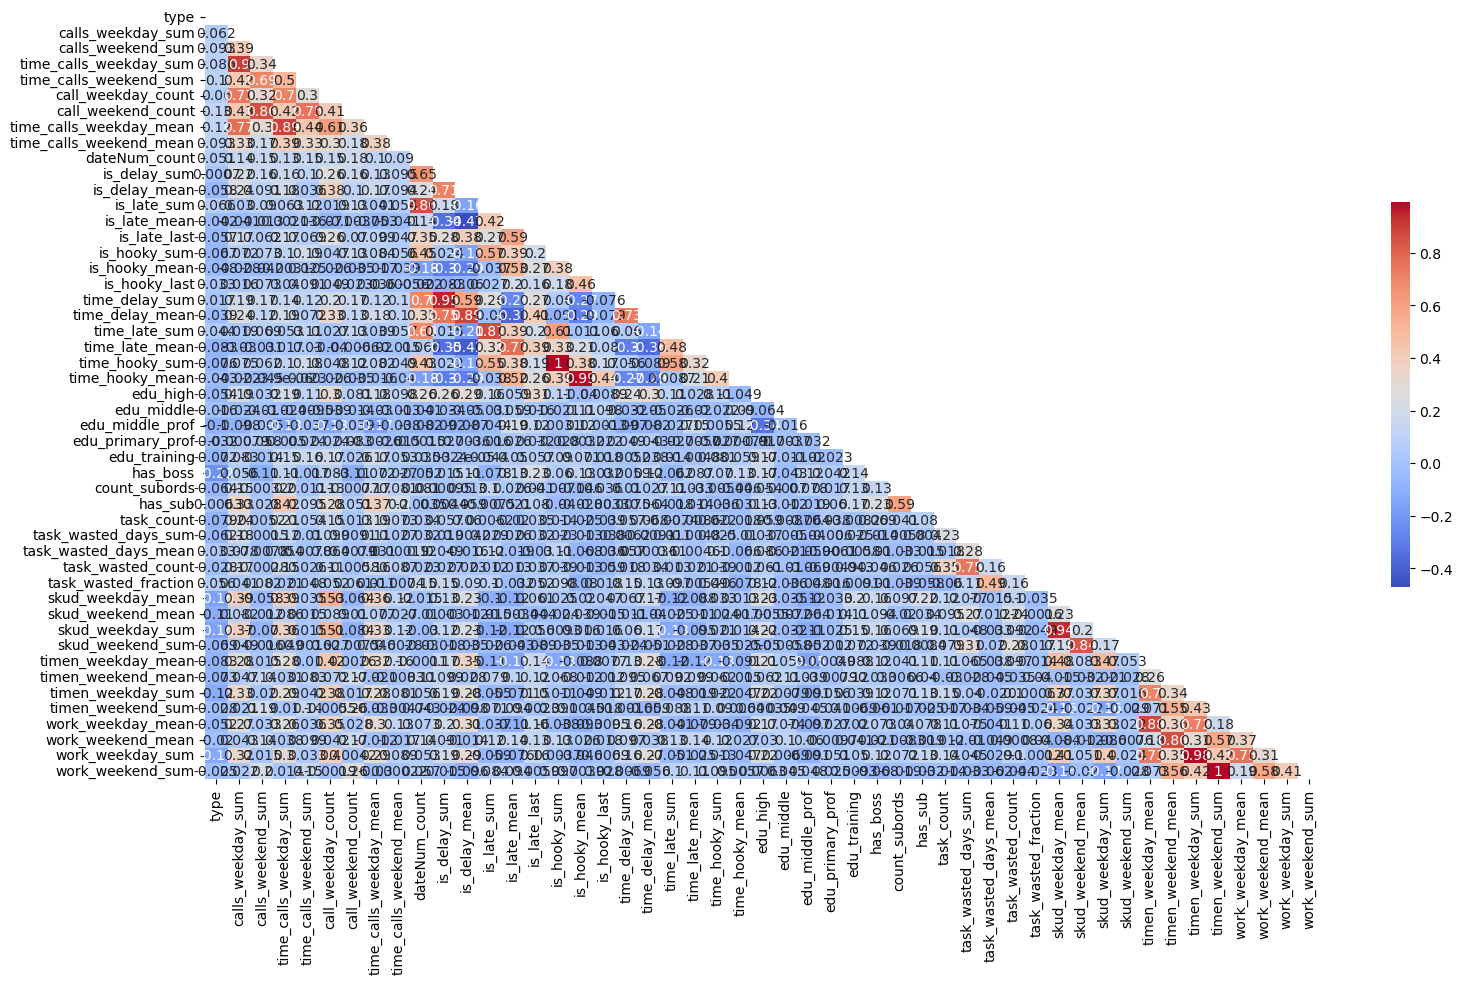

In [121]:
corrMatrix = df_train.corr(method='pearson', min_periods=1)
plt.figure(figsize=(18,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

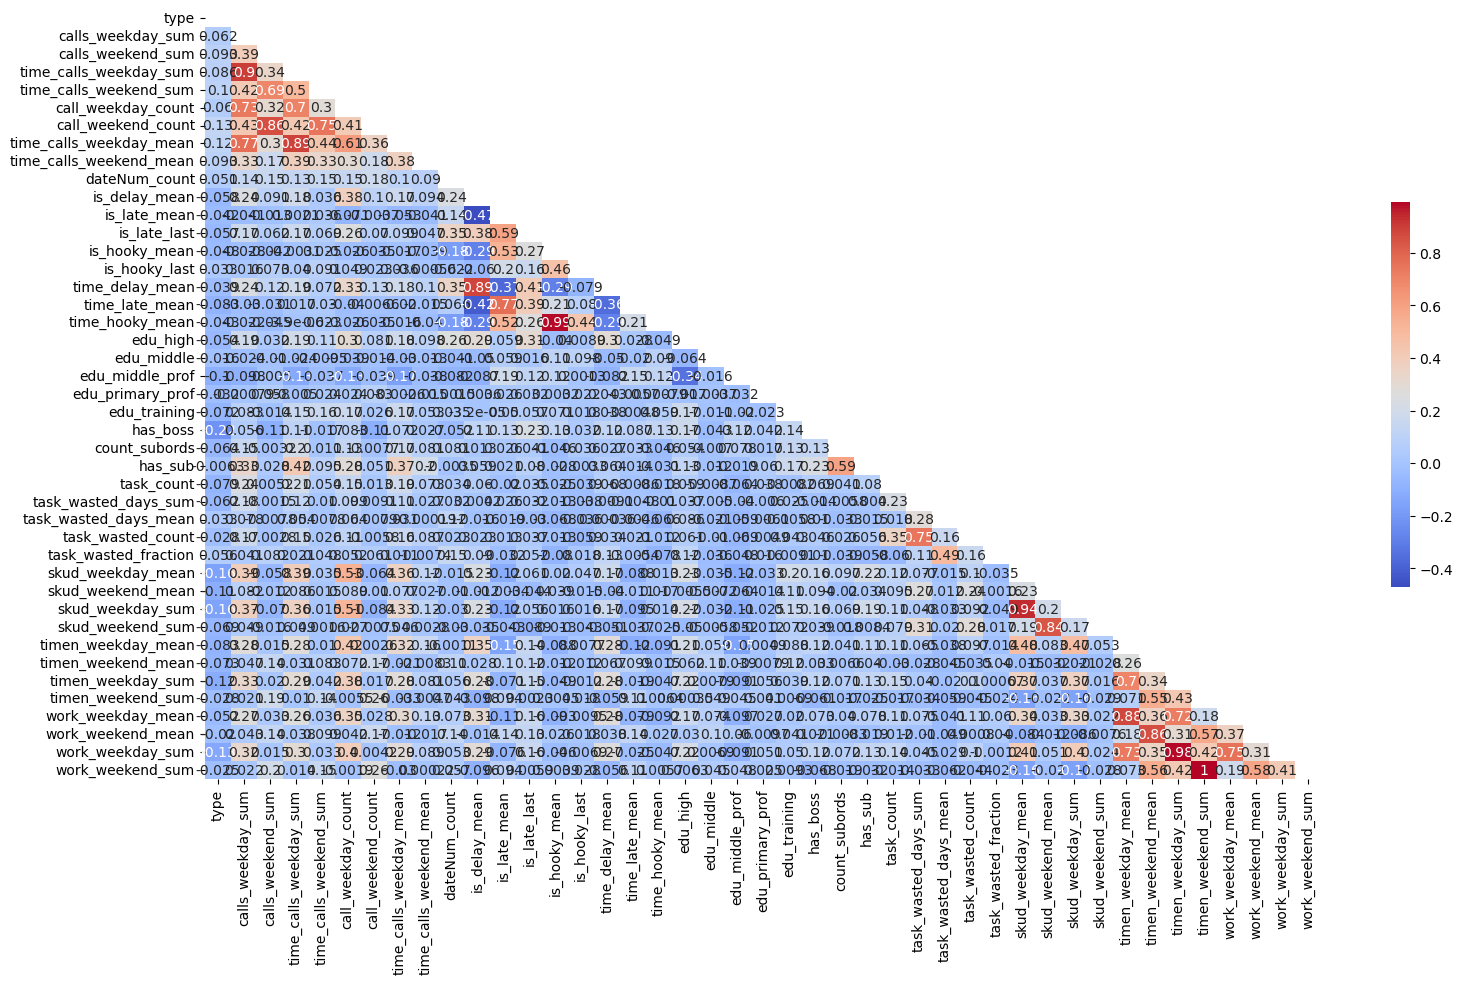

In [122]:
data = df_train.drop(['is_delay_sum', 'is_late_sum', 'is_hooky_sum', 'time_delay_sum', 'time_late_sum', 'time_hooky_sum'], axis=1)
corrMatrix = data.corr(method='pearson', min_periods=1)
plt.figure(figsize=(18,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

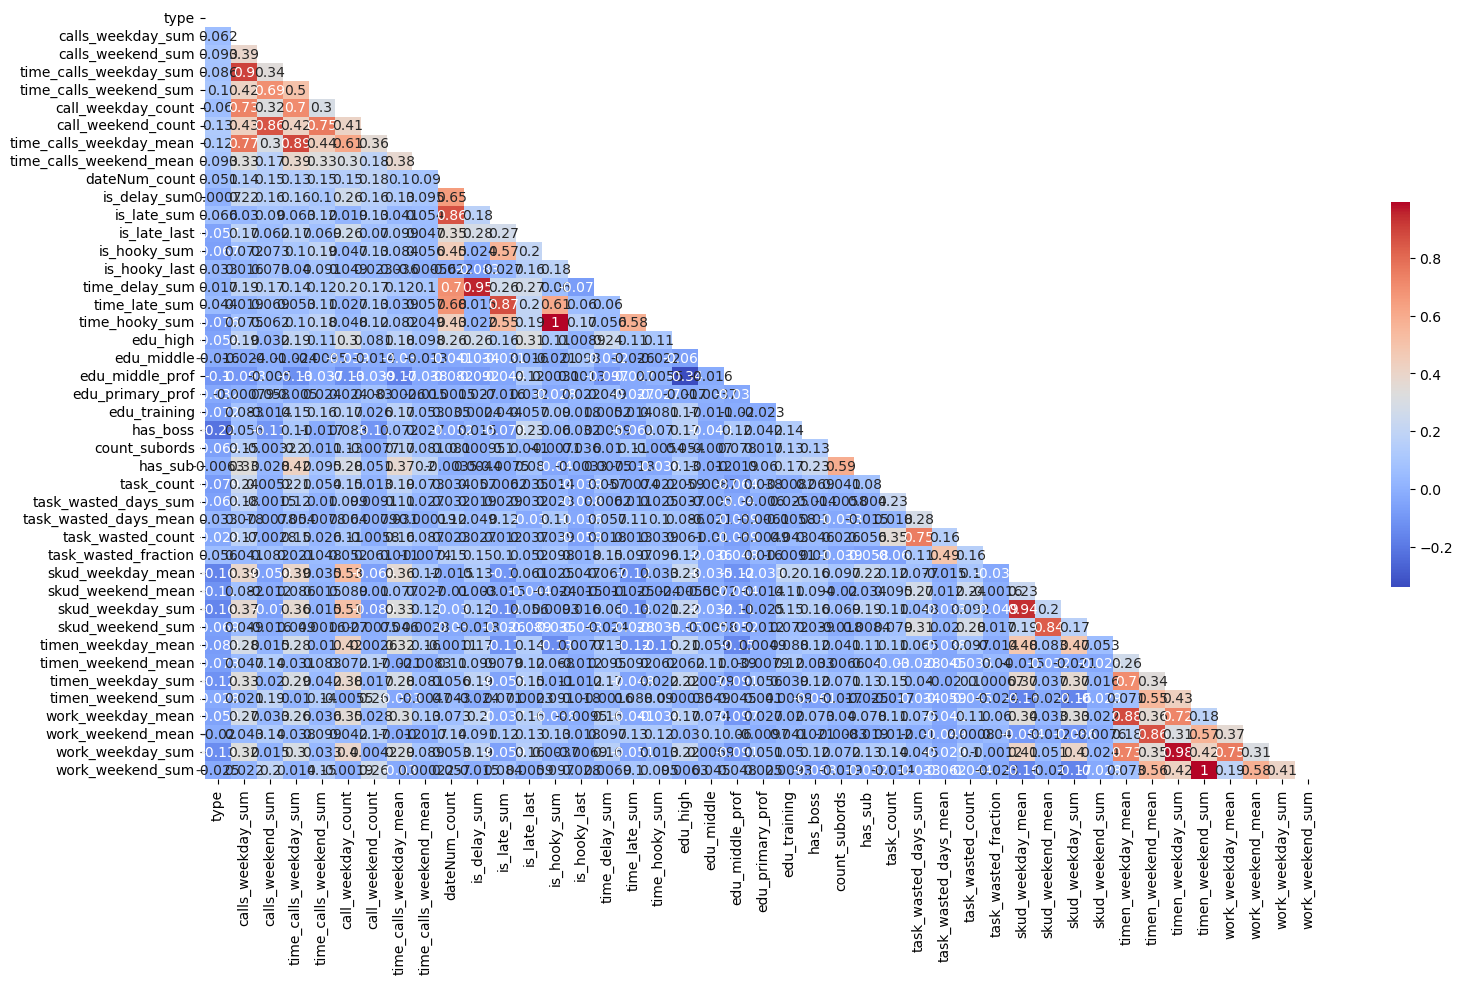

In [123]:
corrMatrix = df_train.drop(['is_delay_mean', 'is_late_mean', 'is_hooky_mean', 'time_delay_mean', 'time_late_mean', 'time_hooky_mean'], axis=1).corr(method='pearson', min_periods=1)
plt.figure(figsize=(18,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

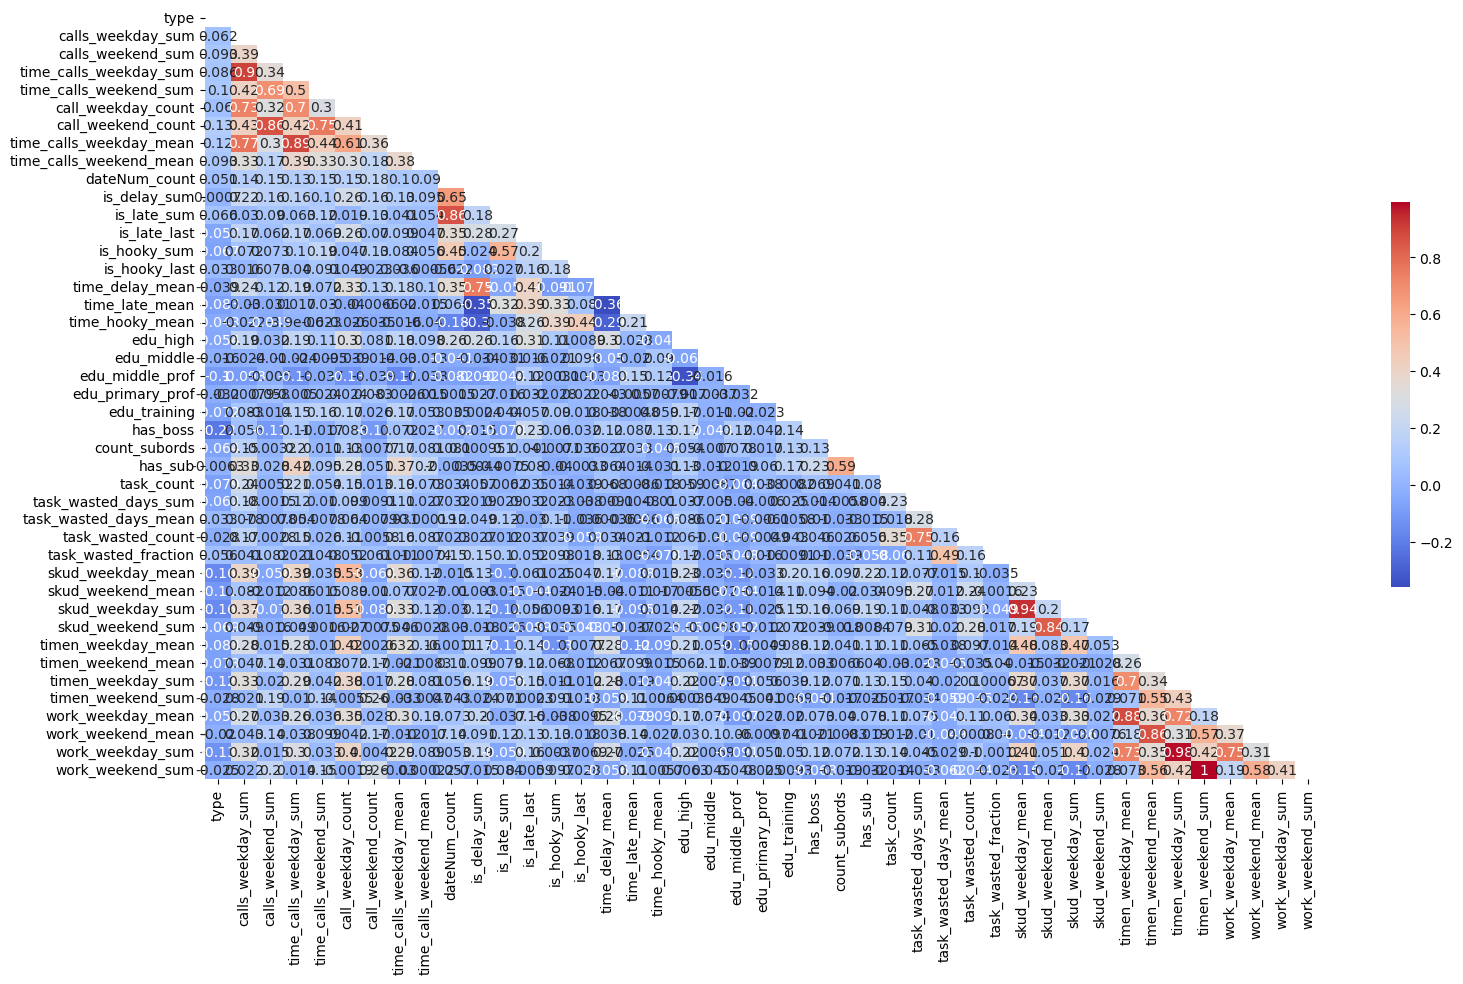

In [124]:
corrMatrix = df_train.drop(['is_delay_mean', 'is_late_mean', 'is_hooky_mean', 'time_delay_sum', 'time_late_sum', 'time_hooky_sum'], axis=1).corr(method='pearson', min_periods=1)
plt.figure(figsize=(18,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

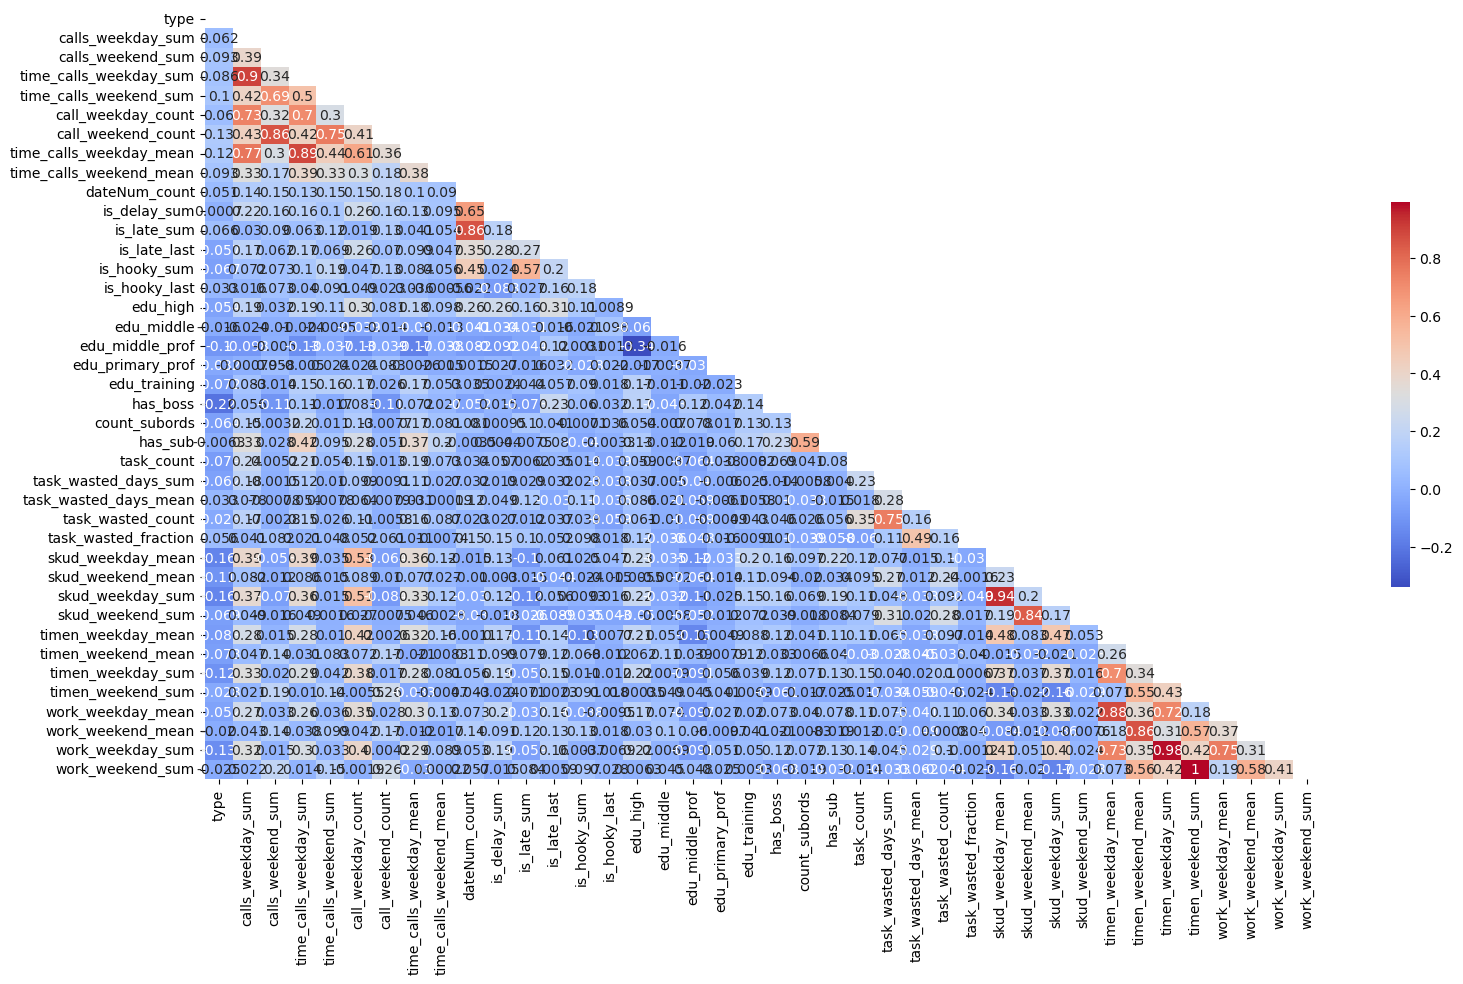

In [125]:
corrMatrix = df_train.drop(['is_delay_mean', 'is_late_mean', 'is_hooky_mean',
                            'time_delay_sum', 'time_late_sum', 'time_hooky_sum',
                            'time_delay_mean', 'time_late_mean', 'time_hooky_mean',
                            ], axis=1).corr(method='pearson', min_periods=1)
plt.figure(figsize=(18,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

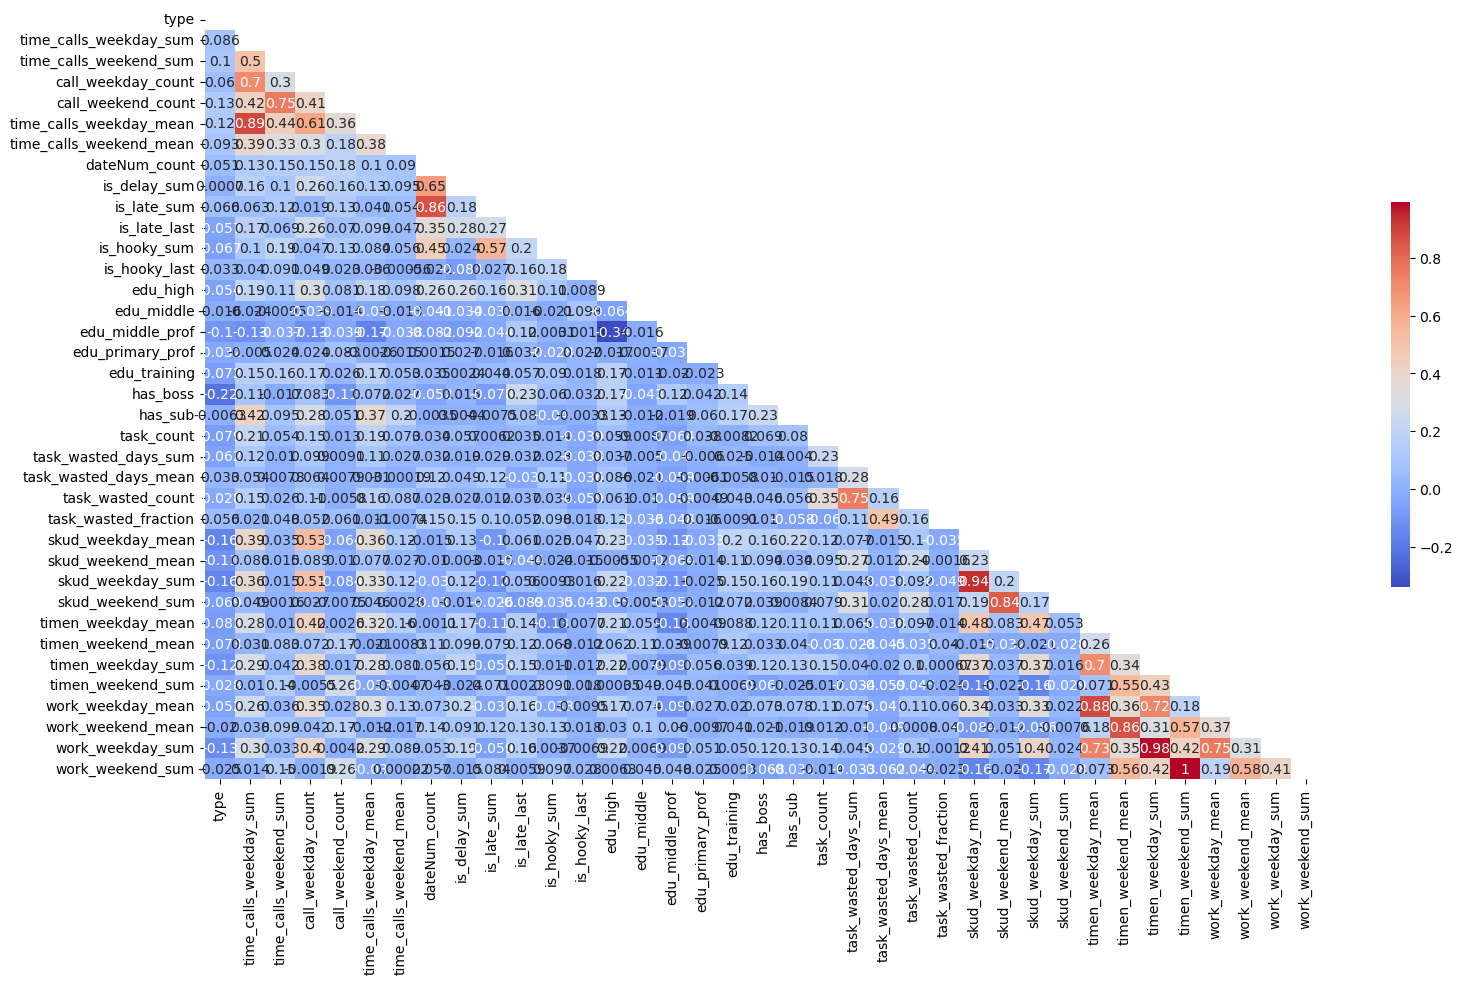

In [126]:
corrMatrix = df_train.drop(['is_delay_mean', 'is_late_mean', 'is_hooky_mean',
                            'time_delay_sum', 'time_late_sum', 'time_hooky_sum',
                            'time_delay_mean', 'time_late_mean', 'time_hooky_mean',
                            'calls_weekday_sum', 'calls_weekend_sum',
                            'count_subords'
                            ], axis=1).corr(method='pearson', min_periods=1)
plt.figure(figsize=(18,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

### Test

In [127]:
df_test = add_features(df_test)
df_test

id  type  calls_weekday_sum  calls_weekend_sum  \
0    ОРГ1-02649     0                4.0                0.0   
1    ОРГ2-05929     0                0.0                0.0   
2    ОРГ2-05859     0                0.0                0.0   
3    ОРГ1-00279     0             8134.0               29.0   
4    ОРГ2-01613     0                0.0                0.0   
..          ...   ...                ...                ...   
257  ОРГ1-02893     0             1357.0               47.0   
258  ОРГ2-01077     0                0.0                0.0   
259  ОРГ1-00469     0             5103.0                0.0   
260  ОРГ1-02060     0             1248.0                3.0   
261  ОРГ2-05042     0                0.0                0.0   

     time_calls_weekday_sum  time_calls_weekend_sum  call_weekday_count  \
0                  0.100833                0.000000                 2.0   
1                  0.000000                0.000000                 0.0   
2                  0.000000                0.000000                 0.0   
3                238.468056                0.678333               212.0   
4                  0.000000                0.000000                 0.0   
..                      ...                     ...                 ...   
257               37.931667                1.112778               214.0   
258                0.000000                0.000000                 0.0   
259              123.926944                0.000000               208.0   
260               23.646111                0.020000               161.0   
261                0.000000                0.000000                 0.0   

     call_weekend_count  time_calls_weekday_mean  time_calls_weekend_mean  \
0                   0.0                 0.050417                 0.000000   
1                   0.0                 0.000000                 0.000000   
2                   0.0                 0.000000                 0.000000   
3                  12.0                 1.124849                 0.056528   
4                   0.0                 0.000000                 0.000000   
..                  ...                      ...                      ...   
257                15.0                 0.177251                 0.074185   
258                 0.0                 0.000000                 0.000000   
259                 0.0                 0.595803                 0.000000   
260                 2.0                 0.146870                 0.010000   
261                 0.0                 0.000000                 0.000000   

     dateNum_count  is_delay_sum  is_delay_mean  is_late_sum  is_late_mean  \
0              0.0           0.0       0.000000          0.0      0.000000   
1             17.0           2.0       0.117647         15.0      0.882353   
2             61.0          32.0       0.524590         29.0      0.475410   
3              9.0           3.0       0.333333          6.0      0.666667   
4             52.0          35.0       0.673077         17.0      0.326923   
..             ...           ...            ...          ...           ...   
257           36.0          23.0       0.638889         13.0      0.361111   
258           50.0          24.0       0.480000         26.0      0.520000   
259            4.0           3.0       0.750000          1.0      0.250000   
260            2.0           1.0       0.500000          1.0      0.500000   
261            9.0           2.0       0.222222          7.0      0.777778   

     is_late_last  is_hooky_sum  is_hooky_mean  is_hooky_last  time_delay_sum  \
0             0.0           0.0       0.000000            0.0        0.000000   
1             1.0          10.0       0.588235            1.0        0.173267   
2             1.0           1.0       0.016393            0.0        3.313647   
3             1.0           1.0       0.111111            0.0        0.344013   
4             1.0           1.0       0.019231            0.0        2.227617   
..     

In [128]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       262 non-null    object 
 1   type                     262 non-null    int64  
 2   calls_weekday_sum        262 non-null    float64
 3   calls_weekend_sum        262 non-null    float64
 4   time_calls_weekday_sum   262 non-null    float64
 5   time_calls_weekend_sum   262 non-null    float64
 6   call_weekday_count       262 non-null    float64
 7   call_weekend_count       262 non-null    float64
 8   time_calls_weekday_mean  262 non-null    float64
 9   time_calls_weekend_mean  262 non-null    float64
 10  dateNum_count            262 non-null    float64
 11  is_delay_sum             262 non-null    float64
 12  is_delay_mean            262 non-null    float64
 13  is_late_sum              262 non-null    float64
 14  is_late_mean             2

In [129]:
df_test.describe()

type  calls_weekday_sum  calls_weekend_sum  time_calls_weekday_sum  \
count  262.0         262.000000         262.000000              262.000000   
mean     0.0        1216.022901          21.553435               38.687004   
std      0.0        1932.936103          84.007497               61.818940   
min      0.0           0.000000           0.000000                0.000000   
25%      0.0           0.000000           0.000000                0.000000   
50%      0.0          91.500000           0.000000                4.776111   
75%      0.0        1537.250000           3.750000               53.639653   
max      0.0        8134.000000         803.000000              377.035556   

       time_calls_weekend_sum  call_weekday_count  call_weekend_count  \
count              262.000000          262.000000          262.000000   
mean                 0.494898           81.763359            3.614504   
std                  1.879241           90.264306           10.642585   
min                  0.000000            0.000000            0.000000   
25%                  0.000000            0.000000            0.000000   
50%                  0.000000           29.000000            0.000000   
75%                  0.055972          172.500000            1.000000   
max                 17.942222          253.000000           74.000000   

       time_calls_weekday_mean  time_calls_weekend_mean  dateNum_count  \
count               262.000000               262.000000     262.000000   
mean                  0.243544                 0.037830      35.259542   
std                   0.428294                 0.100914      34.332181   
min                   0.000000                 0.000000       0.000000   
25%                   0.000000                 0.000000       9.000000   
50%                   0.093113                 0.000000      26.000000   
75%                   0.379188                 0.032778      50.000000   
max                   5.179167                 0.954444     149.000000   

       is_delay_sum  is_delay_mean  is_late_sum  is_late_mean  is_late_last  \
count    262.000000     262.000000   262.000000    262.000000    262.000000   
mean      13.274809       0.342381    21.984733      0.535481      0.862595   
std       15.352838       0.279303    28.902527      0.318881      0.344933   
min        0.000000       0.000000     0.000000      0.000000      0.000000   
25%        1.000000       0.037393     5.000000      0.307975      1.000000   
50%        7.000000       0.363636    13.000000      0.535714      1.000000   
75%       23.000000       0.598649    25.000000      0.814236      1.000000   
max       75.000000       0.887097   140.000000      1.000000      1.000000   

       is_hooky_sum  is_hooky_mean  is_hooky_last  time_delay_sum  \
count    262.000000     262.000000     262.000000      262.000000   
mean       3.332061       0.127162       0.164122        0.874809   
std        3.775354       0.167002       0.371095        1.062279   
min        0.000000       0.000000       0.000000        0.000000   
25%        1.000000       0.014706       0.000000        0.046788   
50%        2.000000       0.079683       0.000000        0.435242   
75%        5.000000       0.166667       0.000000        1.401477   
max       20.000000       1.000000       1.000000        7.028430   

       time_delay_mean  time_late_sum  time_late_mean  time_hooky_sum  \
count       262.000000     262.000000      262.000000      262.000000   
mean          0.021599      20.792037        0.525323       19.309254   
std           0.018132      30.691830        0.439725       22.282896   
min           0.000000       0.000000        0.000000        0.000000   
25%           0.001780       3.827700        0.197746        4.755225   
50%           0.021638      11.164333        0.454735       11.794154   
75%           0.034803      22.654962        0.807305       27.825639   
max           0.074954     253.434880        2.077335      132

## Save

In [130]:
df_train.to_csv('train_features_8.csv', index=False)
df_test.to_csv('test_features_8.csv', index=False)